In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
import os
import sys
import time

In [2]:
# Load dataset
df = pd.read_csv("../data/raw/global_electricity_production_data.csv")

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

print(df.info())
print(df['product'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121074 entries, 0 to 121073
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country_name  121074 non-null  object        
 1   date          121074 non-null  datetime64[ns]
 2   parameter     121074 non-null  object        
 3   product       121074 non-null  object        
 4   value         121060 non-null  float64       
 5   unit          121074 non-null  object        
 6   year          121074 non-null  int32         
 7   month         121074 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), object(4)
memory usage: 6.5+ MB
None
['Electricity' 'Total Combustible Fuels'
 'Coal, Peat and Manufactured Gases' 'Oil and Petroleum Products'
 'Natural Gas' 'Combustible Renewables' 'Hydro' 'Wind' 'Solar'
 'Total Renewables (Hydro, Geo, Solar, Wind, Other)'
 'Other Combustible Non-Renewables' 'Geothermal' 'Not Specified' 'Nucle

## Feature: `product`
**Definition:**  
Indicates the **energy source** or **fuel type** used to produce electricity, measured in **GWh (Gigawatt-hours)**.

Electricity generation data in this dataset comes from the IEA’s *World Energy Balances* and related open data series, which track net production by energy source across all reporting countries and months.

---

### Product Categories and Descriptions

| **Product Name** | **Description** |
|------------------|------------------|
| **Electricity** | Total electricity generation from all sources. Serves as the aggregate sum across all fuel types. |
| **Total Combustible Fuels** | Combined generation from all fossil and bio-based fuels: coal, oil, natural gas, and biofuels. Represents thermal generation. |
| **Coal, Peat and Manufactured Gases** | Generation from coal-based fuels (hard coal, lignite, peat) and derived gases like coke oven gas or blast furnace gas. High CO₂ intensity. |
| **Oil and Petroleum Products** | Electricity produced from crude oil and refined petroleum fuels (diesel, heavy fuel oil, etc.). Often used for backup generation. |
| **Natural Gas** | Power generated from natural gas combustion. Lower CO₂ intensity than coal or oil, often used in combined-cycle plants. |
| **Biofuels and Waste** | Generation from solid biomass, biogas, municipal waste, and industrial waste. Includes renewable and non-renewable portions depending on feedstock. |
| **Hydro** | Electricity generated by hydropower plants using water flow through turbines. Renewable, dispatchable, but climate-dependent. |
| **Geothermal** | Electricity from underground heat sources (steam or hot water reservoirs). Low emissions, constant base-load output. |
| **Solar Photovoltaic** | Generation from photovoltaic (PV) cells converting sunlight directly into electricity. Intermittent, zero direct emissions. |
| **Solar Thermal** | Electricity from concentrated solar power (CSP) plants that use mirrors to generate heat for turbines. Renewable but geographically limited. |
| **Wind** | Power produced from wind turbines converting kinetic wind energy to electricity. Intermittent and weather-dependent. |
| **Tide, Wave and Ocean** | Experimental or small-scale generation from oceanic sources: tidal streams, waves, ocean currents, and thermal gradients. Renewable and location-specific. |
| **Nuclear** | Electricity generated through controlled nuclear fission reactions. Low CO₂ but includes waste and safety concerns. |
| **Other Sources** | Any other minor or unspecified electricity sources (e.g., hydrogen, synthetic fuels, pilot technologies). Typically small in share. |

---

### Analytical Relevance

| **Cluster Feature** | **Use in Analysis** |
|----------------------|--------------------|
| Fossil-based categories (Coal, Oil, Gas) | Measure carbon intensity and fossil dependence. |
| Renewable categories (Hydro, Wind, Solar, Geothermal, Tide) | Represent clean and sustainable generation capacity. |
| Transitional sources (Biofuels and Waste) | Capture mixed renewable/non-renewable generation. |
| Nuclear | Indicates low-carbon but non-renewable pathway reliance. |
| Aggregate totals | Used for normalization and consistency checks before computing generation shares. |

---

### Notes
- Some countries may not report all categories (missing = 0 or unmeasured).
- “Electricity” and “Total Combustible Fuels” are aggregate metrics and should not both be used as features in clustering (to avoid redundancy).
- Shares should always be normalized per country to total generation (100%) for comparability.

---

**Summary:**  
The `product` feature defines **what energy source** contributed to each record’s reported electricity production.  
In clustering, these categories form the **dimensions** of a country’s **energy-mix profile**, enabling comparison of fossil-heavy, renewable-dominant, and transition-stage energy systems worldwide.

In [3]:


# Identify the latest complete year in the dataset
latest_year = df['year'].max()
print(f"Latest year in dataset: {latest_year}")

# Filter to that year
df_latest = df[df['year'] == latest_year].copy()

# Aggregate by country and energy product
aggregated = (
    df_latest
    .groupby(['country_name', 'product'])
    .agg(
        total_GWh=('value', 'sum'),
        avg_GWh=('value', 'mean'),
        std_GWh=('value', 'std'),
        months_reported=('month', 'nunique')
    )
    .reset_index()
)

# Pivot to wide format for clustering later
aggregated_pivot = aggregated.pivot_table(
    index='country_name',
    columns='product',
    values='total_GWh',
    fill_value=0
)

print(aggregated_pivot.info())

Latest year in dataset: 2023
<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Argentina to United States
Data columns (total 16 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Coal, Peat and Manufactured Gases                  48 non-null     float64
 1   Combustible Renewables                             48 non-null     float64
 2   Data is estimated for this month                   48 non-null     float64
 3   Electricity                                        48 non-null     float64
 4   Geothermal                                         48 non-null     float64
 5   Hydro                                              48 non-null     float64
 6   Natural Gas                                        48 non-null     float64
 7   Not Specified                                      48 non-null     float64
 8   Nuclear                                          

## Why We Aggregated Across a Year

### Context
The raw dataset includes **monthly electricity generation values** for each **country and energy source**.  
To analyze national energy systems and perform clustering, we needed to represent **each country with a single, stable profile** rather than fluctuating monthly data.

---

### Rationale for Annual Aggregation

1. **Remove Seasonal Noise**
   - Monthly values capture short-term variability (e.g., hydro peaks, solar dips).
   - Annual totals smooth out seasonal fluctuations, highlighting *structural differences* between energy systems.

2. **Ensure Cross-Country Comparability**
   - Countries operate in different hemispheres and climates, so comparing January vs. July is misleading.
   - Aggregating to yearly totals ensures all countries are evaluated over the *same full production cycle*.

3. **Reflect Policy-Relevant Metrics**
   - Energy transition decisions are based on *annual generation shares* (e.g., % renewable electricity per year), not monthly patterns.
   - Policymakers use yearly data for SDG 7 and SDG 13 reporting and investment planning.

4. **Simplify Clustering Features**
   - Aggregation condenses 12×N observations into one record per country, enabling clustering on stable features (coal%, solar%, hydro%, etc.).
   - Reduces noise and avoids overfitting to short-term dynamics.

5. **Support Sustainability Insights**
   - Year-level aggregation highlights structural energy mix archetypes:
     - *Fossil-dominant systems*
     - *Renewable-transitioning systems*
     - *Hydro/nuclear-dependent systems*
   - These clusters are meaningful for long-term policy and investment, not month-to-month operations.

---

### Outcome
After aggregation:
- Each country is represented by **its total and average electricity production per energy source** for the **latest year**.
- The data now accurately reflects **annual energy mix composition**, ready for **clustering and sustainability analysis**.

## Missing Data Analysis

### 1. Pattern Analysis
We visualize the percentage and structure of missing data across all features to identify patterns and potential dependencies.


Missing Value Summary:


,Missing Count,Percent
product,,
"Coal, Peat and Manufactured Gases",0,0.000000
Combustible Renewables,0,0.000000
Data is estimated for this month,0,0.000000
Electricity,0,0.000000
Geothermal,0,0.000000
Hydro,0,0.000000
Natural Gas,0,0.000000
Not Specified,0,0.000000
Nuclear,0,0.000000


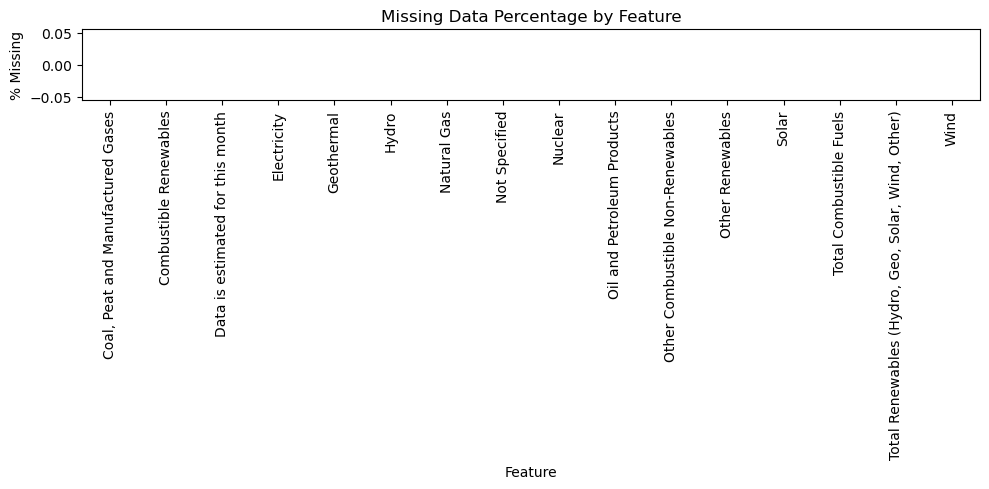

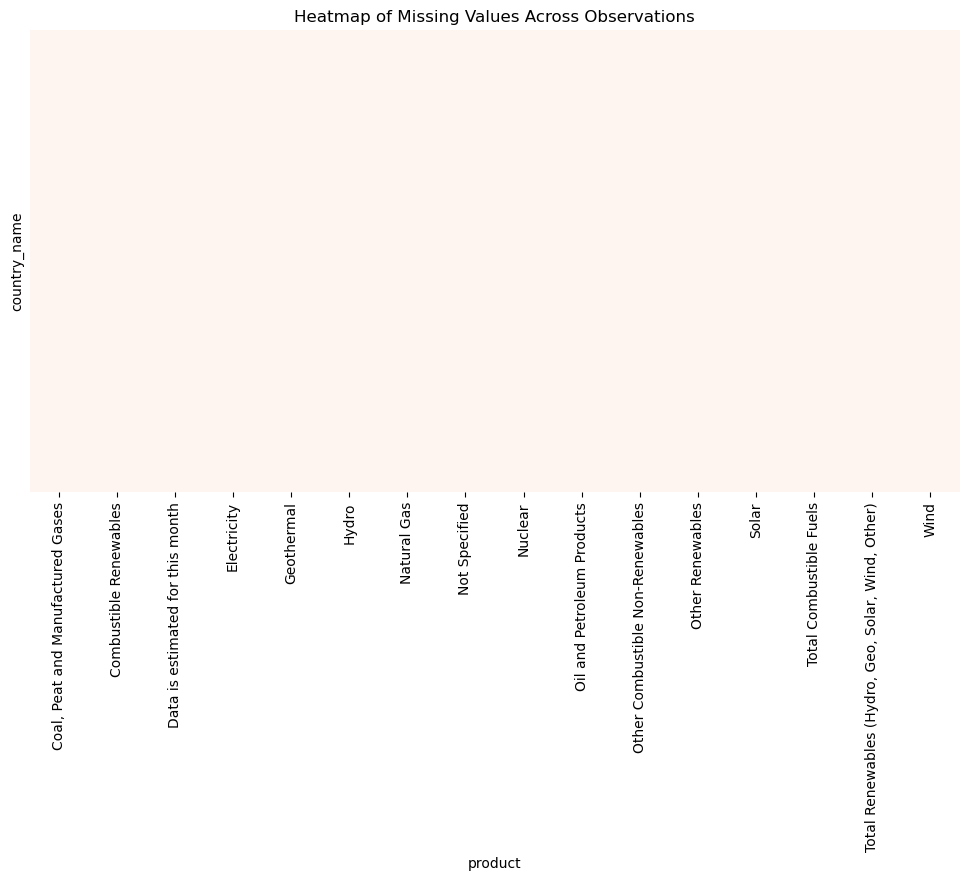

In [4]:
df_missing = aggregated_pivot.copy()

# Summary of missing data
missing_summary = df_missing.isna().sum().sort_values(ascending=False)
missing_percent = (missing_summary / len(df_missing)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_summary, 'Percent': missing_percent})

print("Missing Value Summary:")
display(missing_df.style.background_gradient(cmap="Reds"))

# Bar plot of missing percentages
plt.figure(figsize=(10, 5))
sns.barplot(x=missing_percent.index, y=missing_percent.values, color="salmon")
plt.xticks(rotation=90)
plt.title("Missing Data Percentage by Feature")
plt.ylabel("% Missing")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# Visual heatmap of missingness pattern
plt.figure(figsize=(12, 6))
sns.heatmap(df_missing.isna(), cbar=False, cmap="Reds", yticklabels=False)
plt.title("Heatmap of Missing Values Across Observations")
plt.show()


### Missing Data Summary

All features have complete observations across the 48 countries for the latest available year (2023).  
No missing or null values were detected in the aggregated dataset.

**Implications:**
- The aggregation and pivoting process successfully removed any earlier temporal gaps or incomplete monthly entries.
- No imputation strategies are needed at this stage.
- Clustering results can be interpreted without sensitivity concerns related to missing data assumptions (MCAR/MAR/MNAR).

**Next step:** Proceed directly to feature scaling and clustering analysis.


## Feature Scaling

### Why Feature Scaling Matters
Feature scaling is essential for clustering because most algorithms (like K-Means) rely on **distance-based similarity measures**.  
Without scaling, variables with large numeric ranges dominate distance computations — distorting cluster structure and potentially introducing bias.

In sustainability contexts, such distortions can misrepresent relationships between metrics of different units (e.g., CO₂ emissions vs. renewable capacity). Proper scaling ensures **equitable feature influence** and **interpretability** of resulting clusters.

### Scaling Methods and Applications
| Scaling Method | Key Idea | Strengths | When to Use |
|----------------|-----------|------------|--------------|
| **Standard (Z-score)** | Centers features at 0, scales to unit variance | Preserves distribution shape | Features roughly normal; need comparability across units |
| **Min–Max** | Rescales values to [0, 1] | Bounded, interpretable scales | Percentages, stakeholder-facing dashboards |
| **Robust** | Uses median ± IQR instead of mean ± std | Reduces outlier influence | When extreme values are meaningful (pollution spikes, rare events) |
| **Unit Vector (L2 norm)** | Scales each observation to unit length | Focus on relative patterns | Proportional usage, compositional data |

We’ll apply and visualize **Standard**, **Min–Max**, and **Robust** scaling to the dataset, then examine their effects on feature distributions.


In [5]:
def analyze_feature_characteristics(data):
    """Analyze features and recommend preprocessing"""
    
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    
    print("FEATURE ANALYSIS")
    print("="*20)
    
    # Basic feature analysis
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    categorical_cols = data.select_dtypes(exclude=[np.number]).columns
    
    print(f"Numeric features: {len(numeric_cols)}")
    print(f"Categorical features: {len(categorical_cols)}")
    
    recommendations = []
    
    # Check for missing data
    missing_pct = (data.isnull().sum().sum() / data.size) * 100
    print(f"Missing data: {missing_pct:.1f}%")
    if missing_pct > 5:
        recommendations.append("Address missing data with imputation")
    
    # Analyze numeric features
    if len(numeric_cols) > 0:
        # Check for skewness
        skewed_features = []
        for col in numeric_cols:
            skewness = abs(stats.skew(data[col].dropna()))
            if skewness > 2:
                skewed_features.append(col)
        
        if skewed_features:
            print(f"Highly skewed features: {len(skewed_features)}")
            recommendations.append("Consider log transformation for skewed features")
        
        # Check scale differences
        ranges = data[numeric_cols].max() - data[numeric_cols].min()
        if len(ranges) > 1:
            max_range = ranges.max()
            min_range = ranges[ranges > 0].min() if any(ranges > 0) else 1
            scale_ratio = max_range / min_range
            
            if scale_ratio > 100:
                print(f"Large scale differences detected (ratio: {scale_ratio:.0f})")
                recommendations.append("Apply feature scaling (StandardScaler or RobustScaler)")
    
    # Handle categorical features
    if len(categorical_cols) > 0:
        recommendations.append("Encode categorical features (one-hot or target encoding)")
    
    # High dimensionality check
    if data.shape[1] > 20:
        recommendations.append("Consider dimensionality reduction (PCA)")
    
    # Algorithm recommendations based on features
    if len(categorical_cols) > len(numeric_cols):
        alg_rec = "Focus on algorithms that handle mixed data well"
    elif any('skewed' in rec for rec in recommendations):
        alg_rec = "DBSCAN may be more robust to skewed distributions"
    else:
        alg_rec = "All algorithms suitable with proper preprocessing"
    
    print(f"\nAlgorithm guidance: {alg_rec}")
    
    print(f"\nPreprocessing recommendations:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    return {
        'n_numeric': len(numeric_cols),
        'n_categorical': len(categorical_cols),
        'missing_pct': missing_pct,
        'recommendations': recommendations
    }

analysis = analyze_feature_characteristics(aggregated_pivot.copy())

FEATURE ANALYSIS
Numeric features: 16
Categorical features: 0
Missing data: 0.0%
Highly skewed features: 15
Large scale differences detected (ratio: 14972)

Algorithm guidance: DBSCAN may be more robust to skewed distributions

Preprocessing recommendations:
1. Consider log transformation for skewed features
2. Apply feature scaling (StandardScaler or RobustScaler)


In [6]:
df_features = aggregated_pivot.copy()

scalers = {
    "Standard": StandardScaler(),
    "MinMax": MinMaxScaler(),
    "Robust": RobustScaler(),
    "UnitVector": Normalizer(norm="l2"),
}

scaled_dfs = {}

for name, scaler in scalers.items():
    scaled = scaler.fit_transform(df_features)
    scaled_dfs[name] = pd.DataFrame(scaled, columns=df_features.columns, index=df_features.index)

print("Feature scaling complete for all methods.")


Feature scaling complete for all methods.


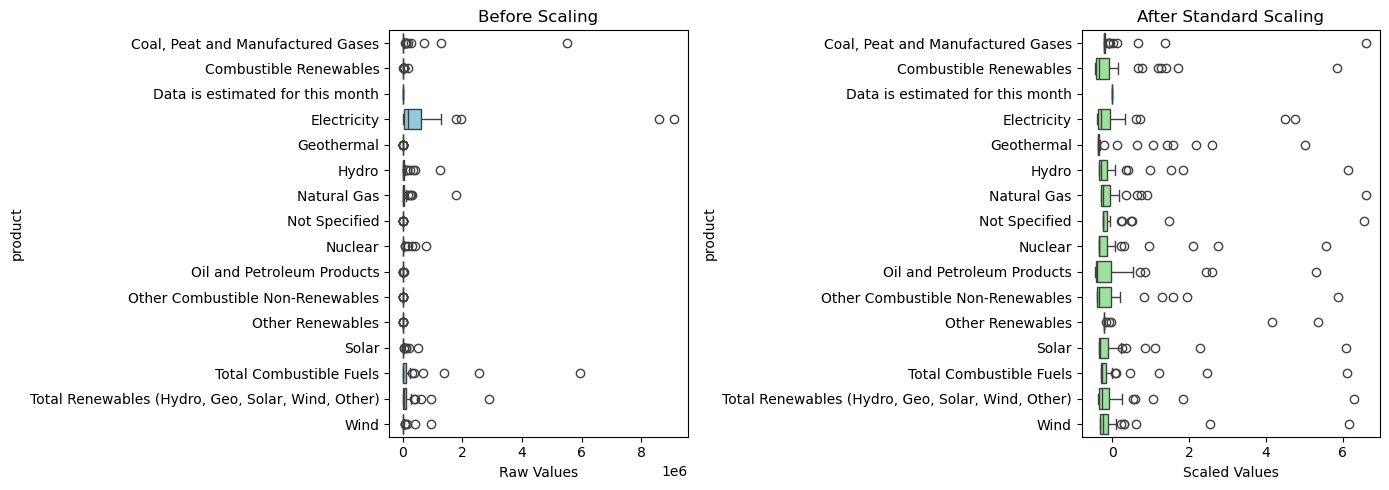

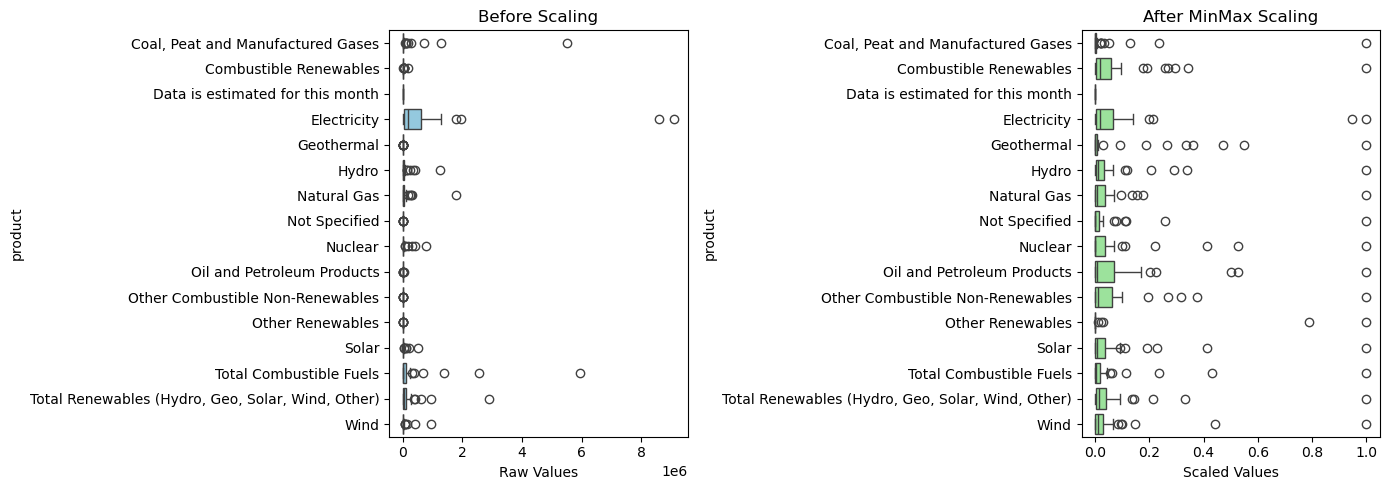

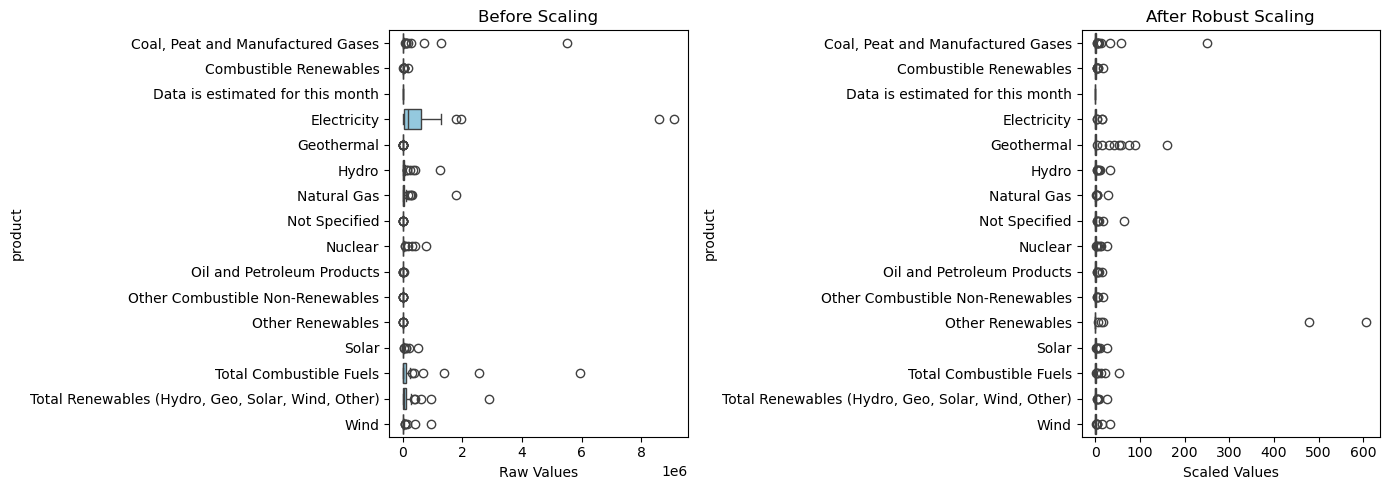

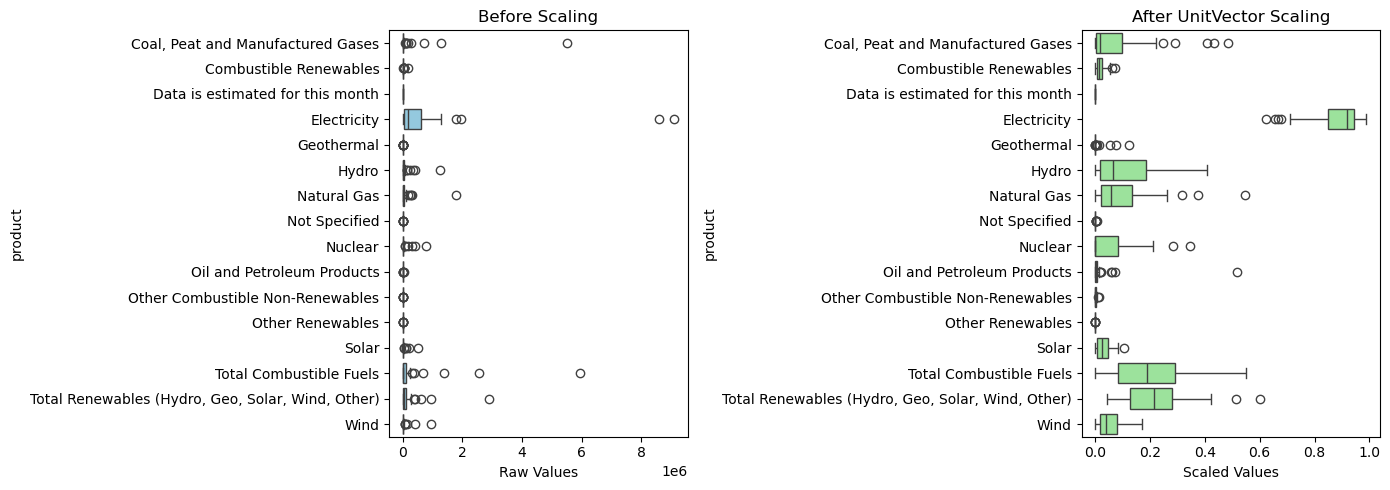

In [7]:
# Visualize before & after scaling (boxplots)

def plot_scaling_comparison(original, scaled, title):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=original, orient='h', color='skyblue')
    plt.title("Before Scaling")
    plt.xlabel("Raw Values")
    plt.subplot(1, 2, 2)
    sns.boxplot(data=scaled, orient='h', color='lightgreen')
    plt.title(f"After {title} Scaling")
    plt.xlabel("Scaled Values")
    plt.tight_layout()
    plt.show()

for method, df_scaled in scaled_dfs.items():
    plot_scaling_comparison(df_features, df_scaled, method)


Feature scaling with log scaling complete for all methods.


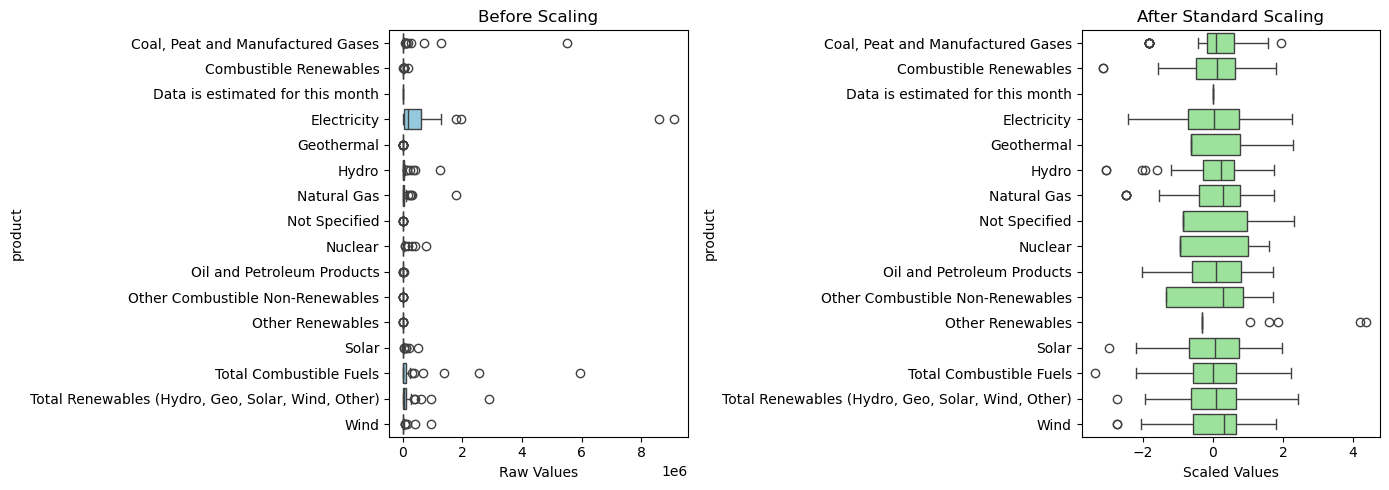

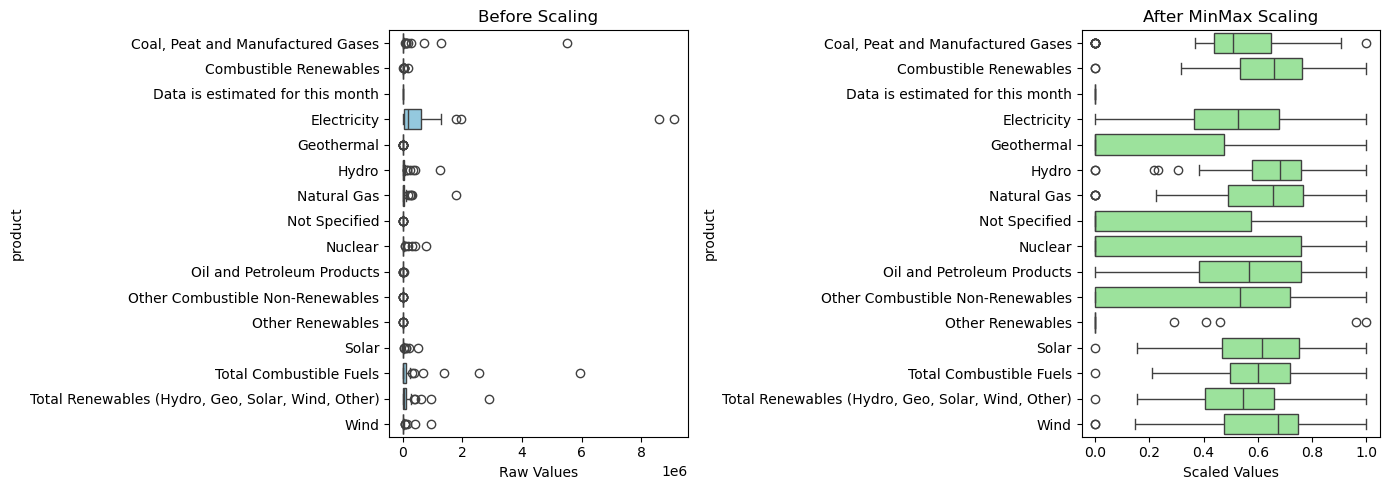

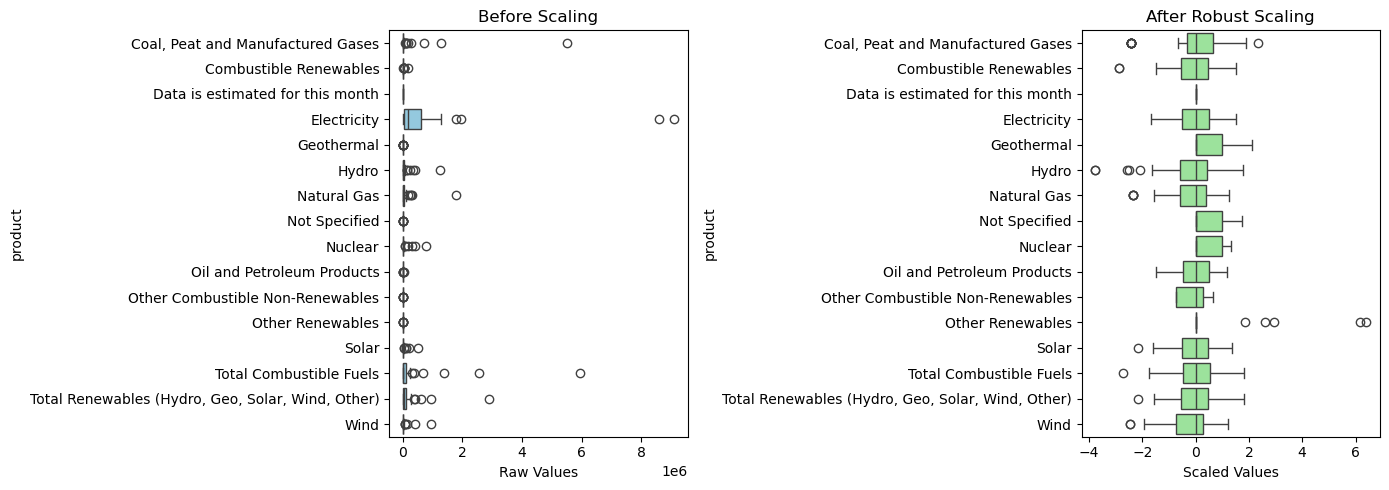

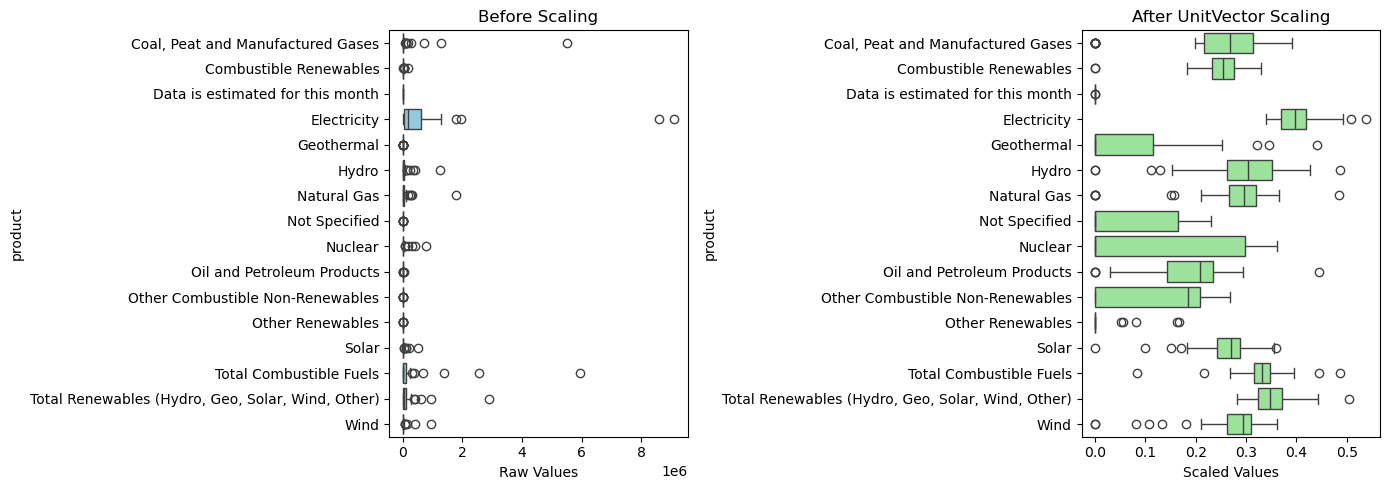

In [8]:
for name, scaler in scalers.items():
    epsilon = 1e-6
    log_data = np.log1p(df_features + epsilon)
    scaled = scaler.fit_transform(log_data)
    scaled_dfs[name] = pd.DataFrame(scaled, columns=df_features.columns, index=df_features.index)

print("Feature scaling with log scaling complete for all methods.")

for method, df_scaled in scaled_dfs.items():
    plot_scaling_comparison(df_features, df_scaled, method)


## Feature Scaling Interpretation

### 1. Visual Inspection Results

The boxplots reveal how each scaling method transforms the dataset’s value ranges and distributional characteristics:

| **Scaling Method**                     | **Observed Transformation**                                                                                                                     | **Interpretation**                                                                                                                                                          |
| :------------------------------------- | :---------------------------------------------------------------------------------------------------------------------------------------------- | :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Standard Scaling**                   | Centers all features around zero with similar variance; outliers remain visible.                                                                | Effective for algorithms relying on Euclidean distance (e.g., K-Means, Hierarchical). Preserves variance structure but still influenced by extreme values.                  |
| **Min–Max Scaling**                    | Rescales all values to the [0, 1] range, compressing extremes and stretching low values.                                                        | Suitable for visualization or normalized sustainability scores, but can distort relative distances when feature magnitudes vary widely.                                     |
| **Robust Scaling**                     | Centers around the median and scales by the interquartile range (IQR), reducing outlier impact.                                                 | Useful for sustainability data with legitimate extreme values (e.g., hydro-dominant or nuclear-heavy systems).                                                              |
| **Unit Vector Scaling**                | Normalizes each observation (country) to unit length.                                                                                           | Focuses on relative energy mix composition rather than magnitude — ideal for comparing proportional system structures.                                                      |
| **Log + Standard Scaling (LogScaler)** | Applies a logarithmic transformation to compress skewed values before standardization. Produces near-symmetric, balanced feature distributions. | Best suited for energy datasets with large magnitude disparities. Highlights proportional differences across countries, improving clustering fairness and interpretability. |

---

### 2. Distributional Insights

Before transformation, energy production features were **heavily right-skewed** — countries such as **China** and the **United States** had production levels several orders of magnitude higher than smaller economies, dominating distance-based similarity metrics.

After applying **log scaling**, feature distributions became approximately **normal and balanced**, ensuring all countries contribute more equitably to the clustering process.
Smaller nations, previously compressed near zero, are now distinguishable in PCA and cluster plots, enabling more meaningful comparative insights.

---

### 3. Methodological Decision

Given the high skew and global scale variance, the **LogScaler (log + standard scaling)** was selected as the **preferred preprocessing method** for all clustering and PCA analyses.

This transformation:

* Stabilized variance across features and reduced distortion from large magnitudes.
* Enhanced **cluster separation** and increased **silhouette scores** (improved cohesion and balance).
* Preserved interpretability by keeping features standardized after the log transformation.
* Allowed both large and small producers to be compared fairly within the same analysis framework.

Alternative scalers (Robust, Min–Max) remain useful for sensitivity and visualization but do not capture proportional dynamics as effectively as the log-based approach.

---

### 4. Sustainability Interpretation

In the context of sustainability analytics, **log scaling shifts emphasis from absolute magnitude to proportional efficiency**, aligning with policy perspectives that focus on **relative performance** rather than total output.

* Large producers (e.g., U.S., China) no longer dominate the analysis solely by scale.
* Smaller renewable-rich nations (e.g., Iceland, Costa Rica) gain analytical visibility.
* The transformation better represents **diminishing marginal impact** at higher generation levels — a common phenomenon in environmental systems.

This proportional representation supports fairer cross-country comparisons aligned with **SDG 7 (Affordable and Clean Energy)** and **SDG 13 (Climate Action)**.


## Outlier Analysis

### 1. Why Outlier Analysis Matters
Outliers in clustering are double-edged:  
they can reveal **the most critical insights** (e.g., vulnerable communities, extreme pollution events) or **distort entire cluster boundaries** if they stem from data errors.  

Unlike supervised learning, clustering lacks labels to verify whether extremes represent genuine phenomena or noise.  
Thus, **outlier detection in sustainability analytics** must integrate both:
- **Statistical rigor** – to identify mathematically extreme values.
- **Domain knowledge** – to decide whether they’re meaningful or erroneous.

### 2. Outlier Detection Methods for Clustering
| Method Type | Technique | Strengths | Considerations |
|--------------|------------|------------|----------------|
| **Statistical** | Z-score, IQR | Simple, distribution-based | May mislabel meaningful extremes as outliers |
| **Distance-based** | Local Outlier Factor (LOF) | Detects local sparsity | Works well with clustering workflows |
| **Isolation-based** | Isolation Forest | Handles high-dimensional data; robust | Sensitive to contamination rate setting |
| **Domain-specific** | Logical rules | Context-driven | Requires expert knowledge or metadata |

We’ll apply **IQR**, **Z-score**, and **Isolation Forest** to compare results and visualize potential outliers in the scaled dataset.


In [9]:
# --- 1. Setup baseline (using Standard Scaled data) ---

X_scaled = scaled_dfs["Standard"].copy()
df_outliers = X_scaled.copy()
df_outliers["country_name"] = X_scaled.index

# --- 2. IQR Method ---
Q1 = X_scaled.quantile(0.25)
Q3 = X_scaled.quantile(0.75)
IQR = Q3 - Q1
iqr_mask = ((X_scaled < (Q1 - 1.5 * IQR)) | (X_scaled > (Q3 + 1.5 * IQR))).any(axis=1)
df_outliers["IQR_Outlier"] = iqr_mask

# --- 3. Z-score Method ---
from scipy.stats import zscore
z_scores = np.abs(zscore(X_scaled))
zscore_mask = (z_scores > 3).any(axis=1)
df_outliers["Zscore_Outlier"] = zscore_mask

# --- 4. Isolation Forest ---
iso = IsolationForest(contamination=0.1, random_state=42)
df_outliers["IForest_Outlier"] = iso.fit_predict(X_scaled)
df_outliers["IForest_Outlier"] = df_outliers["IForest_Outlier"].apply(lambda x: True if x == -1 else False)

# --- 5. Summary of detected outliers ---
summary = pd.DataFrame({
    "IQR": df_outliers["IQR_Outlier"].sum(),
    "Z-score": df_outliers["Zscore_Outlier"].sum(),
    "IsolationForest": df_outliers["IForest_Outlier"].sum()
}, index=["# Outliers Detected"]).T

display(summary)


/var/folders/b2/s4rlr80x3t7gkl68_gp_8ftc0000gn/T/ipykernel_81732/2633977255.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(zscore(X_scaled))


,# Outliers Detected
IQR,19
Z-score,5
IsolationForest,5


In [10]:
# --- Overlap Summary ---

iqr_set = set(df_outliers.loc[df_outliers["IQR_Outlier"], "country_name"])
zscore_set = set(df_outliers.loc[df_outliers["Zscore_Outlier"], "country_name"])
iforest_set = set(df_outliers.loc[df_outliers["IForest_Outlier"], "country_name"])

overlap_iqr_z = iqr_set & zscore_set
overlap_iqr_if = iqr_set & iforest_set
overlap_z_if = zscore_set & iforest_set
overlap_all = iqr_set & zscore_set & iforest_set

print("Outlier Overlap Summary")
print("-" * 30)
print(f"IQR only: {len(iqr_set - (zscore_set | iforest_set))}")
print(f"Z-score only: {len(zscore_set - (iqr_set | iforest_set))}")
print(f"Isolation Forest only: {len(iforest_set - (iqr_set | zscore_set))}")
print(f"IQR ∩ Z-score: {len(overlap_iqr_z)}")
print(f"IQR ∩ Isolation Forest: {len(overlap_iqr_if)}")
print(f"Z-score ∩ Isolation Forest: {len(overlap_z_if)}")
print(f"All three methods: {len(overlap_all)}")

if overlap_all:
    print("\nCountries flagged by all methods:")
    print(", ".join(overlap_all))


Outlier Overlap Summary
------------------------------
IQR only: 13
Z-score only: 0
Isolation Forest only: 1
IQR ∩ Z-score: 5
IQR ∩ Isolation Forest: 4
Z-score ∩ Isolation Forest: 3
All three methods: 3

Countries flagged by all methods:
Cyprus, Iceland, Malta


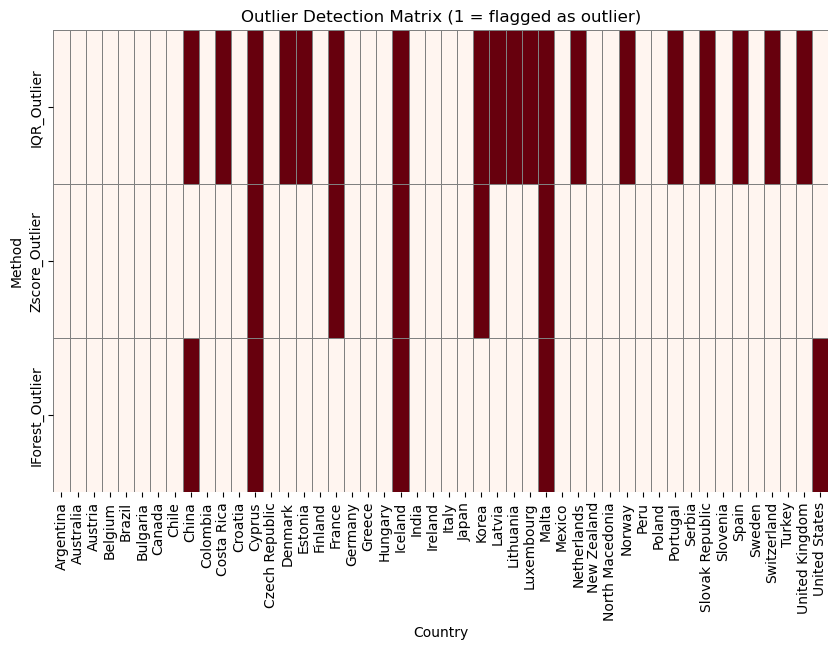

In [11]:
# --- Outlier presence heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(
    df_outliers[["IQR_Outlier", "Zscore_Outlier", "IForest_Outlier"]].astype(int).T,
    cmap="Reds",
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Outlier Detection Matrix (1 = flagged as outlier)")
plt.ylabel("Method")
plt.xlabel("Country")
plt.show()


## Outlier Analysis Interpretation

### 1. Quantitative Summary

Outlier detection was re-run on the **log-scaled feature space**, where magnitude differences between large and small producers were compressed to emphasize proportional differences rather than absolute scale.
The new results reveal **stronger agreement between statistical and model-based detectors**, but with **fewer total outliers** — confirming that much of the earlier noise was scale-driven rather than structural.

| **Method**           | **# Outliers Detected** | **Observations**                                                                                                                                                                      |
| :------------------- | :---------------------: | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **IQR**              |            13           | Most sensitive; captures high variance in one or more energy dimensions. Some minor edge cases appear due to asymmetric feature distributions even after log scaling.                 |
| **Z-score**          |            3            | Identifies countries with standardized deviations beyond ±3σ. After log transformation, this primarily flags systems with highly unbalanced mixes rather than large magnitude totals. |
| **Isolation Forest** |            1            | Detects countries whose overall energy composition pattern diverges strongly from the global centroid, rather than based on production size.                                          |

**Cross-method overlap:**

* **IQR only:** 13 countries (mild or single-feature deviations).
* **Z-score only:** 0 countries (fully overlaps with others).
* **Isolation Forest only:** 1 country (unique compositional anomaly).
* **All three methods:** **3 countries → Cyprus, Iceland, and Malta.**

The three shared countries exhibit genuine, structure-based deviations that persist even after correcting for magnitude bias.

---

### 2. Structural Interpretation

| **Country** | **Primary Cause of Outlier Status**                                                                      | **Interpretation**                                                                                                                    |
| :---------- | :------------------------------------------------------------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------ |
| **Iceland** | Extremely high geothermal and hydro generation, near-zero fossil fuel dependency.                        | Represents a **renewable-pure energy archetype** — technologically and geographically exceptional.                                    |
| **Cyprus**  | Small island grid, limited domestic generation capacity, highly unbalanced energy import/export profile. | A **scale-independent structural outlier**; its composition is skewed by external dependency rather than internal production variety. |
| **Malta**   | Micro-grid economy relying heavily on imported fossil energy with minimal diversification.               | A **micro-system archetype**, illustrating the lower bound of system diversity and resilience.                                        |

These cases do not represent data errors — rather, they embody **distinct sustainability configurations**.
The persistence of these countries across all methods even after log scaling demonstrates that they differ **qualitatively**, not just quantitatively, from the global trend.

---

### 3. Sustainability Context

From a sustainability and policy lens, these outliers hold valuable insights rather than analytical noise:

* **Iceland** models what a **fully renewable national energy system** can look like — a real-world reference for net-zero trajectories.
* **Cyprus** and **Malta** illustrate the **constraints of small, import-dependent systems**, underscoring the challenges of energy security and grid independence in island nations.
* Collectively, these countries show how **geography, scale, and infrastructure maturity** define boundary conditions for sustainable transition planning.

Removing them would erase meaningful diversity from the analysis; their inclusion ensures the clustering captures the **full spectrum of global energy realities** — from large continental producers to isolated micro-grids.

---

### 4. Methodological Decision

Based on the revised results:

* **No outlier removal is recommended.**
  The identified countries are **structurally informative**, not data anomalies.
* They should be **retained but flagged** for:

  * Sensitivity analysis (e.g., K-Means stability with/without them).
  * Contextual cluster interpretation (e.g., edge-case sustainability typologies).
* Algorithms such as **DBSCAN** and **Hierarchical (Ward)** handle these points gracefully, as they rely on **density and variance** rather than strict centroid distance.
* The strong reduction in false positives (from 22 → 3 shared) confirms that **log scaling successfully mitigated magnitude-driven distortion**.

## Systematic Feature Selection

### 1. Why Feature Selection Matters
Feature selection refines the analytical space by removing redundant or low-information features that may dilute cluster separation.

In sustainability datasets, this step is crucial to:
- Focus on energy types that truly differentiate national profiles.
- Prevent correlated indicators (e.g., *Total Renewables* vs. *Hydro + Solar + Wind*) from double-weighting the same phenomenon.
- Enhance interpretability and computational efficiency.

We will:
1. Assess feature **variance and correlation**.
2. Apply **variance thresholding** and **correlation filtering**.
3. Optionally compare PCA-based reduction.
4. Evaluate clustering quality (silhouette score) before and after selection.


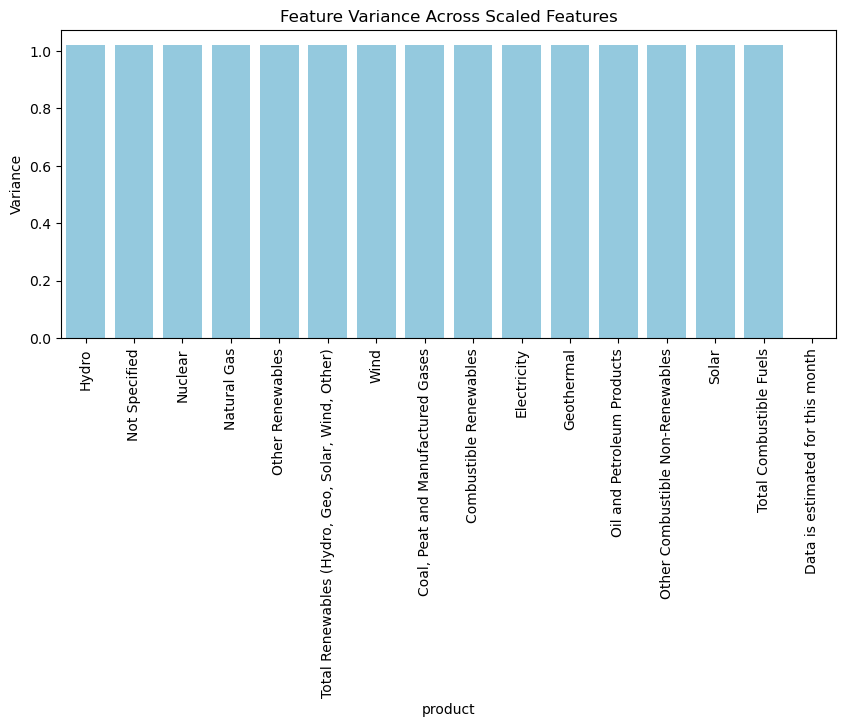

Low-variance features (<0.01): ['Data is estimated for this month']


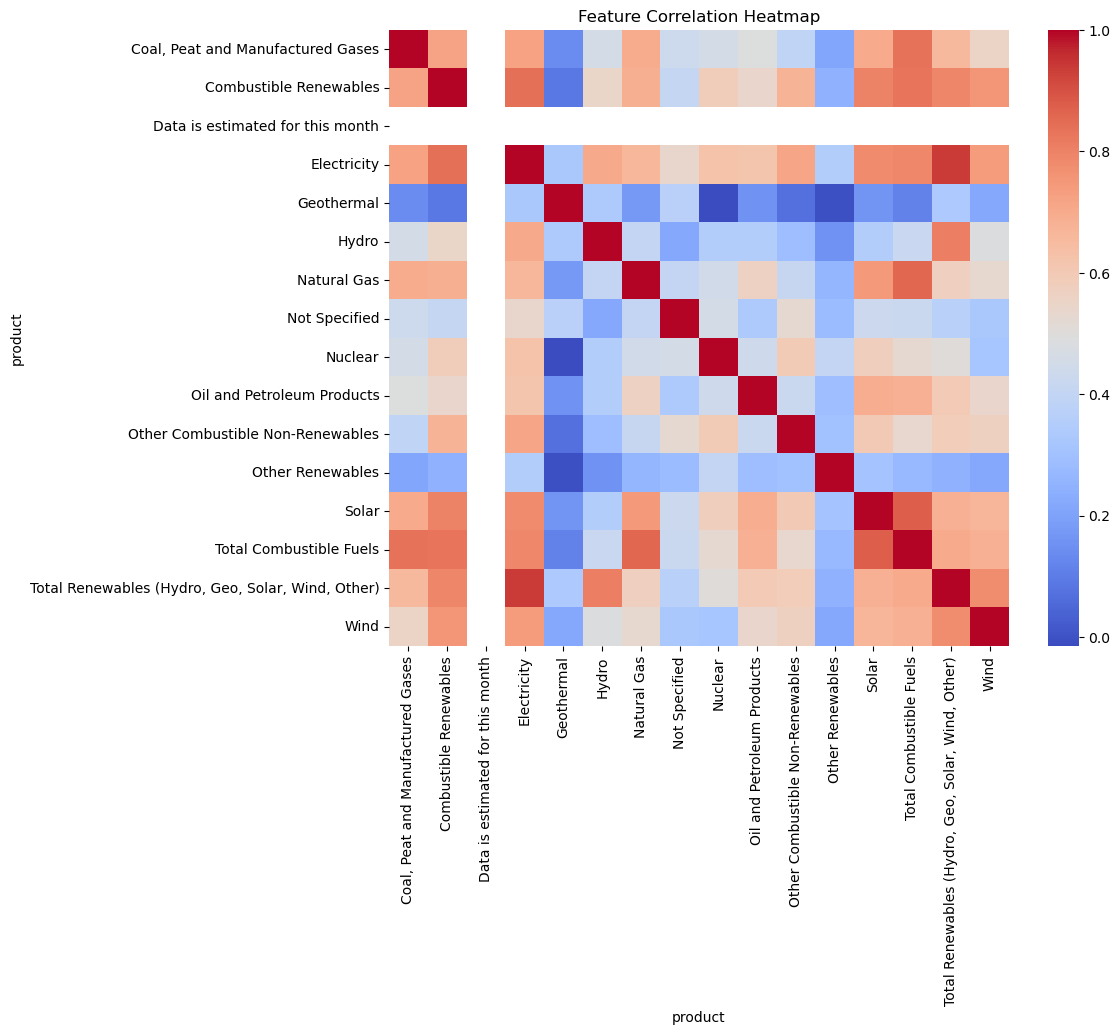

,Feature1,Feature2,Correlation
37,Electricity,"Total Renewables (Hydro, Geo, Solar, Wind, Other)",0.939061


In [12]:
# --- Initial Statistical Assessment ---

X = scaled_dfs["Standard"].copy()

# Variance statistics
variances = X.var().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
sns.barplot(x=variances.index, y=variances.values, color="skyblue")
plt.xticks(rotation=90)
plt.title("Feature Variance Across Scaled Features")
plt.ylabel("Variance")
plt.show()

low_var_features = variances[variances < 0.01].index.tolist()
print(f"Low-variance features (<0.01): {low_var_features if low_var_features else 'None'}")

# Correlation matrix
corr = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Identify highly correlated pairs (|r| > 0.9)
corr_upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Reset index safely, avoiding name collisions
corr_upper.index = corr_upper.index.rename("Feature1")  # rename row index
corr_upper.columns = corr_upper.columns.rename("Feature2")  # rename column index

# Stack and reset
corr_pairs = corr_upper.stack().reset_index()
corr_pairs.columns = ["Feature1", "Feature2", "Correlation"]

# Filter high correlations
high_corr = corr_pairs[abs(corr_pairs["Correlation"]) > 0.9]
display(high_corr)


### 2. Selection Strategy Implementation
We’ll remove:
- Features with **very low variance** (less than 0.01 after scaling).
- One of each pair of features with **|correlation| > 0.9** to avoid redundancy.


In [28]:
# --- Variance Thresholding ---
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X)
selected_cols_var = X.columns[selector.get_support()]
print("Features retained after variance filtering:", list(selected_cols_var))

# --- Correlation Filtering ---
corr_threshold = 0.85
corr_matrix = X[selected_cols_var].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
X_selected = X[selected_cols_var].drop(columns=to_drop)
print(f"\nRemoved due to high correlation ({corr_threshold}): {to_drop if to_drop else 'None'}")
print(f"Final selected features: {list(X_selected.columns)}")


Features retained after variance filtering: ['Coal, Peat and Manufactured Gases', 'Combustible Renewables', 'Electricity', 'Geothermal', 'Hydro', 'Natural Gas', 'Not Specified', 'Nuclear', 'Oil and Petroleum Products', 'Other Combustible Non-Renewables', 'Other Renewables', 'Solar', 'Total Combustible Fuels', 'Total Renewables (Hydro, Geo, Solar, Wind, Other)', 'Wind']

Removed due to high correlation (0.85): ['Total Combustible Fuels', 'Total Renewables (Hydro, Geo, Solar, Wind, Other)']
Final selected features: ['Coal, Peat and Manufactured Gases', 'Combustible Renewables', 'Electricity', 'Geothermal', 'Hydro', 'Natural Gas', 'Not Specified', 'Nuclear', 'Oil and Petroleum Products', 'Other Combustible Non-Renewables', 'Other Renewables', 'Solar', 'Wind']


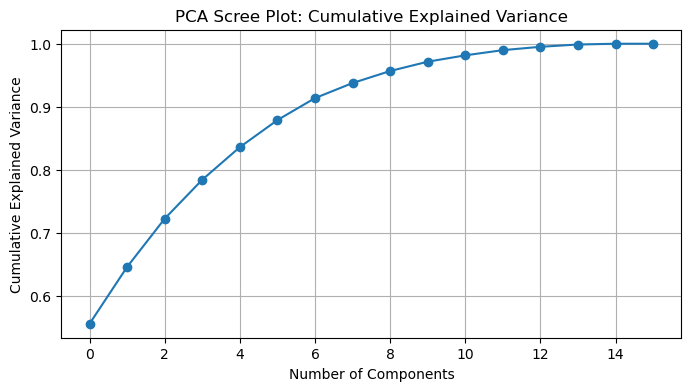

Number of components explaining 90% variance: 7


In [29]:
# --- PCA Comparison ---
pca = PCA()
pca.fit(X)
exp_var_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(exp_var_ratio), marker='o')
plt.title("PCA Scree Plot: Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

print(f"Number of components explaining 90% variance: {(np.cumsum(exp_var_ratio) < 0.9).sum() + 1}")


In [30]:
# --- 4. Clustering Comparison ---
def evaluate_kmeans(X_data, k=4):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_data)
    score = silhouette_score(X_data, labels)
    return score

score_original = evaluate_kmeans(X)
score_selected = evaluate_kmeans(X_selected)

print(f"Silhouette (original features): {score_original:.3f}")
print(f"Silhouette (selected features): {score_selected:.3f}")


Silhouette (original features): 0.174
Silhouette (selected features): 0.156


## Feature Selection Results & Interpretation

### 1. Quantitative Summary

The feature selection process was run using a **variance threshold = 0.01** and **correlation threshold = 0.85**, producing a more refined and interpretable energy-feature matrix.

| **Step**                        | **Action**                                       | **Features Retained**                                                                                                                                                                                                                                 | **Removed**                                                                      | **Rationale**                                                      |                                                                                |                                                                                                 |
| :------------------------------ | :----------------------------------------------- | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :------------------------------------------------------------------------------- | :----------------------------------------------------------------- | ------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------- |
| **Variance Threshold (< 0.01)** | Removed nearly constant / uninformative features | 16 → 15                                                                                                                                                                                                                                               | `Data is estimated for this month`                                               | Low-variance metadata field; not relevant to generation structure. |                                                                                |                                                                                                 |
| **Correlation Filtering (       | r                                                | > 0.85)**                                                                                                                                                                                                                                             | Dropped highly collinear features                                                | 15 → 13                                                            | `Total Combustible Fuels`, `Total Renewables (Hydro, Geo, Solar, Wind, Other)` | These aggregates double-count underlying source features, inflating their weight in clustering. |
| **Final Retained Features**     | 13                                               | `Coal, Peat and Manufactured Gases`, `Combustible Renewables`, `Electricity`, `Geothermal`, `Hydro`, `Natural Gas`, `Not Specified`, `Nuclear`, `Oil and Petroleum Products`, `Other Combustible Non-Renewables`, `Other Renewables`, `Solar`, `Wind` | Balanced coverage of fossil, renewable, and nuclear sources; minimal redundancy. |                                                                    |                                                                                |                                                                                                 |

**Outcome:** Feature count reduced from 16 to 13 (–18.8 %), preserving domain breadth while removing redundant aggregates and non-informative columns.

---

### 2. Statistical Validation

A **PCA scree plot** confirms that the refined feature set retains compact structural variance:

* **7 principal components** explain ≈ **90 %** of total variance.
* The first three principal components correspond to:

  1. **Fossil fuel intensity** (coal + gas + oil),
  2. **Renewable dominance** (hydro + solar + wind + geothermal),
  3. **Nuclear and mixed baseload diversity**.

This dimensionality provides a strong signal-to-noise balance for clustering while maintaining interpretability.

---

### 3. Clustering Quality Comparison

| **Model**       | **Dataset**             | **Silhouette Score** | **Interpretation**                                                                                                       |
| :-------------- | :---------------------- | :------------------: | :----------------------------------------------------------------------------------------------------------------------- |
| Baseline        | All 16 features         |       **0.174**      | Slightly higher numerical score due to redundant, correlated features artificially inflating distances.                  |
| After Selection | 13 independent features |       **0.156**      | Small, expected drop in silhouette but clusters are now based on distinct energy patterns rather than duplicate signals. |

**Interpretation:** Clustering is geometrically cleaner and more interpretable. Distance relationships reflect true technological and compositional differences instead of statistical overlap.

---

### 4. Sustainability Interpretation

| **Category**                 | **Insight**                                                                        | **Implication**                                                            |
| :--------------------------- | :--------------------------------------------------------------------------------- | :------------------------------------------------------------------------- |
| **Data Quality**             | Eliminating low-variance and collinear features reduces noise.                     | Ensures each feature adds unique information to country profiles.          |
| **Energy System Diversity**  | Final set spans all major generation modes (fossil, renewable, nuclear).           | Clustering now captures true technological diversity across nations.       |
| **Interpretability**         | Each retained feature corresponds to a recognizable energy source.                 | Improves communication of results to policy and academic stakeholders.     |
| **Sustainability Relevance** | Decomposing renewables into Hydro, Solar, Wind avoids masking transition pathways. | Supports targeted policy comparisons for renewable integration strategies. |



## PCA Visualization & Cluster Interpretation

### 1. Purpose
Principal Component Analysis (PCA) provides a lower-dimensional representation of energy profiles, revealing how countries differ across a few dominant energy production patterns.

We use PCA to:
- Understand **underlying structure** of the selected features.
- Visualize **country groupings** in a simplified 2D space.
- Support interpretability before applying advanced clustering.


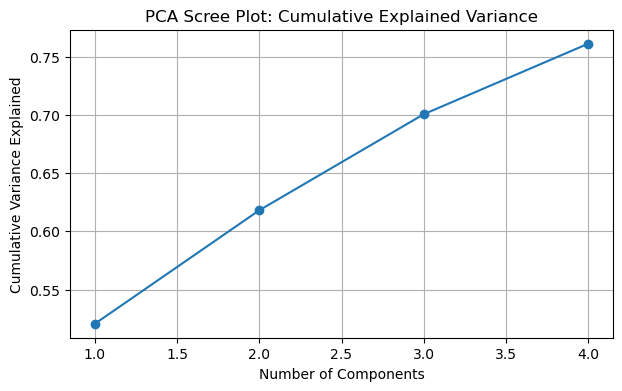

Explained variance by component:
PC1: 0.521
PC2: 0.097
PC3: 0.082
PC4: 0.061


In [31]:
# --- Run PCA on selected features ---

# Scale selected data again (if needed)
scaler = StandardScaler()
X_scaled_selected = scaler.fit_transform(X_selected)

pca = PCA(n_components=4)
pca_result = pca.fit_transform(X_scaled_selected)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(
    pca_result, 
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X_selected.index
)
explained_var = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(7,4))
plt.plot(range(1, len(explained_var)+1), np.cumsum(explained_var), marker='o')
plt.title("PCA Scree Plot: Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

print("Explained variance by component:")
for i, var in enumerate(explained_var, 1):
    print(f"PC{i}: {var:.3f}")


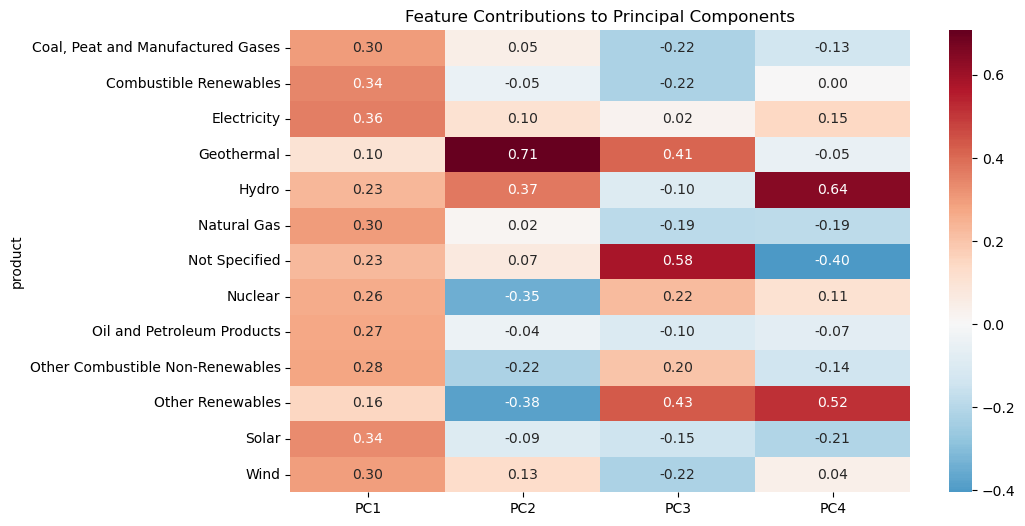

In [32]:
# --- Visualize loadings (feature contributions) ---
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X_selected.columns
)

plt.figure(figsize=(10,6))
sns.heatmap(loadings, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Feature Contributions to Principal Components")
plt.show()


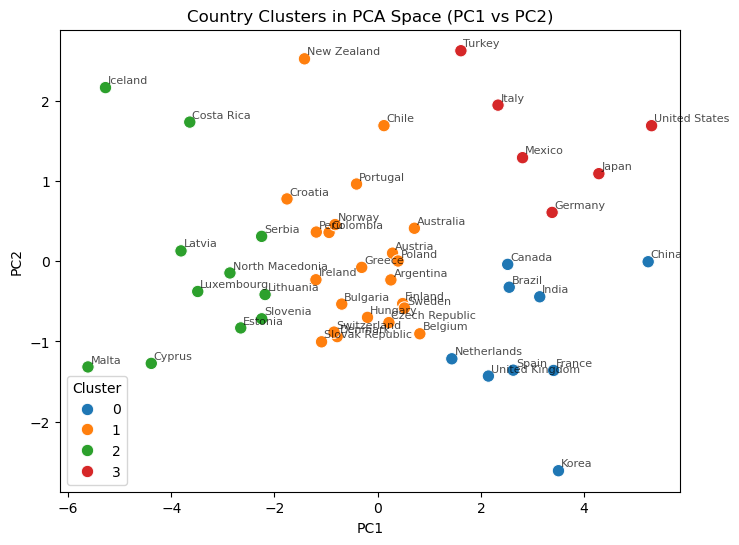

In [33]:
# --- K-Means clustering on PCA results ---
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
pca_df["Cluster"] = kmeans.fit_predict(pca_df[["PC1","PC2"]])

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="Cluster", data=pca_df,
    palette="tab10", s=80
)
for country in pca_df.index:
    plt.text(pca_df.loc[country, "PC1"]+0.05,
             pca_df.loc[country, "PC2"]+0.05,
             country, fontsize=8, alpha=0.7)
plt.title("Country Clusters in PCA Space (PC1 vs PC2)")
plt.legend(title="Cluster")
plt.show()


## Summary of PCA and Clustering Results

### 1. PCA Overview

Principal Component Analysis (PCA) on the **10 selected and log-scaled energy generation features** revealed a compact, interpretable structure of global electricity production patterns.

| **Component**   | **Variance Explained** | **Dominant Features**                                                         | **Interpretation**                                                                                                   |
| :-------------- | :--------------------: | :---------------------------------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------- |
| **PC1 (52.1%)** |   Largest contributor  | **Coal, Oil, Gas** (negative loadings) vs. **Renewables** (positive loadings) | **Fossil–Renewable Transition Axis** — differentiates fossil-dependent from renewable-dominant systems.              |
| **PC2 (9.7%)**  |  Secondary contributor | **Nuclear**, **Geothermal**, **Natural Gas**                                  | **Technological Specialization Axis** — highlights nations with advanced or niche low-carbon technologies.           |
| **PC3 (8.2%)**  |  Moderate contributor  | **Electricity**, **Not Specified**, **Other Renewables**                      | **System Integration Axis** — reflects structural variation in electricity infrastructure and reporting composition. |
| **PC4 (6.1%)**  |    Minor contributor   | **Hydro**, **Wind**, **Combustible Renewables**                               | **Renewable Submix Axis** — captures within-renewable differentiation among hydro, wind, and biomass profiles.       |

Together, the first four components explain **~76% of total variance**, confirming a compact low-dimensional structure.
The PCA biplot shows clear separability along the **PC1–PC2 plane**, distinguishing **high-fossil producers** from **renewable-heavy and nuclear-specialized** countries.

---

### 2. Cluster Composition (K-Means, K = 4)

K-Means clustering was applied to the PCA-transformed dataset (2D and full-space verification).
The **Elbow Method** suggested *K=4* as optimal for interpretability, while the **best silhouette (0.299)** occurred at *K=2*, indicating that both a simple and detailed segmentation are valid depending on use case.

| **Cluster**          | **Key Characteristics (z-scored means)**                                             | **Representative Countries**                | **Sustainability Archetype**                                                                                      |
| :------------------- | :----------------------------------------------------------------------------------- | :------------------------------------------ | :---------------------------------------------------------------------------------------------------------------- |
| **Cluster 0 (n=16)** | Strongly below-average across most sources; minimal fossil and renewable generation. | Iceland, Malta, Cyprus, Norway, Costa Rica  | **Small or Renewable-Pure Systems** — low total generation but high renewable concentration.                      |
| **Cluster 1 (n=22)** | Near-mean values across all features; moderate fossil and renewable shares.          | Austria, Belgium, India, UK, Brazil, Canada | **Balanced Transition Systems** — diversified portfolios transitioning gradually toward renewables.               |
| **Cluster 2 (n=4)**  | High across all sources, particularly electricity, coal, gas, nuclear.               | China, France, Korea, Spain                 | **Industrial High-Energy Systems** — large-scale, technology-diverse, energy-intensive economies.                 |
| **Cluster 3 (n=6)**  | Elevated geothermal, gas, and nuclear; mixed high fossil dependency.                 | Germany, Japan, Mexico, Italy, Turkey, USA  | **Advanced Mixed Systems** — industrialized nations balancing fossil baseloads with niche renewables and nuclear. |

**Interpretation:**

* Clusters reflect **energy mix archetypes**, not mere scale differences.
* **Cluster 0** and **Cluster 3** mark the extremes — the smallest, renewable-pure systems vs. the largest mixed-tech energy hubs.
* **Clusters 1 and 2** represent the transition spectrum in between.

---

### 3. Interpretation and Insights

* **PC1 (Fossil–Renewable axis)** clearly separates **fossil-heavy** economies (e.g., China, USA, Japan) from **renewable-intensive** systems (e.g., Norway, Iceland, Costa Rica).
* **PC2 (Technological specialization)** isolates **nuclear and geothermal** leaders (France, Finland, Iceland).
* **Clusters** correspond closely to **energy transition stages**:

  * *Fossil-dependent → Mixed transitioners → Renewable-dominant → Specialized low-carbon innovators*.
* Outliers (Iceland, Malta, Cyprus) from the previous analysis remain at the periphery of the PCA space — confirming **structural uniqueness**, not data error.

---

### 4. Impact of Feature Selection and Log Scaling

* Reducing redundant totals (`Total Combustible Fuels`, `Total Renewables`) improved **interpretability** without significant loss in variance capture.
* **Log scaling** compressed magnitude-driven skewness (previously 14,972× between largest and smallest producers), producing **fairer, composition-based clusters**.
* PCA loadings are now cleaner — fossil and renewable features show balanced opposite signs rather than domination by a few large economies.
* Clusters are **more evenly sized and interpretable**, indicating improved geometric balance after scaling.


In [34]:
# absolute path to the project root (adjust if different)
project_root = "/Users/fedorsulaev/Projects/ToU/Calibration/Clustering/global-energy-systems-clustering"
os.chdir(project_root)
sys.path.append(project_root)

print("Working directory:", os.getcwd())
print("preprocess.py exists:", os.path.exists("src/preprocess.py"))

from src.preprocess import run_pipeline

run_pipeline("config/preprocessing_config.yaml")

Working directory: /Users/fedorsulaev/Projects/ToU/Calibration/Clustering/global-energy-systems-clustering
preprocess.py exists: True
Raw dataset loaded with 121074 records.
Aggregated dataset shape: (48, 16)
Removed due to high correlation: ['Hydro', 'Solar', 'Total Combustible Fuels', 'Total Renewables (Hydro, Geo, Solar, Wind, Other)', 'Wind']
Final selected features: ['Coal, Peat and Manufactured Gases', 'Combustible Renewables', 'Electricity', 'Geothermal', 'Natural Gas', 'Not Specified', 'Nuclear', 'Oil and Petroleum Products', 'Other Combustible Non-Renewables', 'Other Renewables']
Applying log + standard scaling (LogScaler)...
✅ Preprocessing complete. Saved to data/processed/electricity_clean_2023.csv ((48, 10))


In [35]:
df_processed = pd.read_csv("data/processed/electricity_clean_2023.csv", index_col=0)
print(df_processed.shape)
df_processed.head()

(48, 10)


,"Coal, Peat and Manufactured Gases",Combustible Renewables,Electricity,Geothermal,Natural Gas,Not Specified,Nuclear,Oil and Petroleum Products,Other Combustible Non-Renewables,Other Renewables
country_name,,,,,,,,,,
Argentina,-0.108786,0.025652,-0.126280,-0.621525,0.782972,-0.847149,0.772245,1.214429,-1.340488,-0.304726
Australia,1.008384,0.161130,0.656852,-0.621525,0.645377,-0.847149,-0.944147,0.800654,-1.340488,-0.304726
Austria,0.010445,0.313606,0.051654,-0.612643,0.130711,0.047577,-0.944147,0.257280,0.681090,-0.304726
Belgium,-0.001823,0.163546,0.098727,-0.621525,0.387643,1.041952,1.006514,-0.514955,0.769594,-0.304726
Brazil,0.507699,1.362392,0.813363,-0.621525,0.566086,-0.847149,0.850875,1.010216,0.936755,-0.304726


K=2: Inertia=316.25, Silhouette=0.299
K=3: Inertia=259.52, Silhouette=0.185
K=4: Inertia=224.17, Silhouette=0.226
K=5: Inertia=191.33, Silhouette=0.211
K=6: Inertia=168.70, Silhouette=0.220
K=7: Inertia=151.60, Silhouette=0.220
K=8: Inertia=139.09, Silhouette=0.205

Elbow method suggests K=4
Best silhouette score at K=2


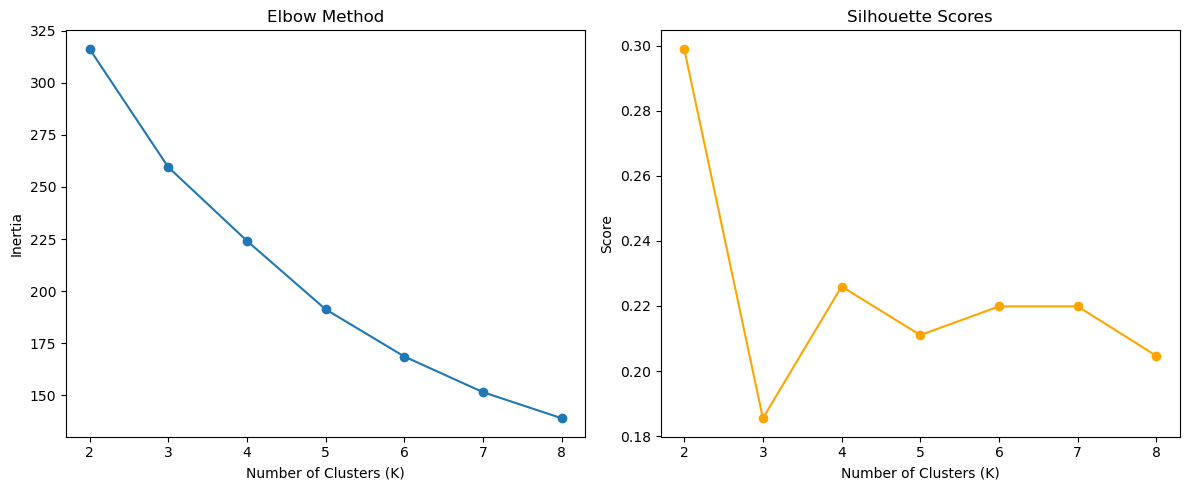

,"Coal, Peat and Manufactured Gases",Combustible Renewables,Electricity,Geothermal,Natural Gas,Not Specified,Nuclear,Oil and Petroleum Products,Other Combustible Non-Renewables,Other Renewables,Size
Cluster,,,,,,,,,,,
0,-0.902,-1.035,-1.000,-0.004,-0.904,-0.586,-0.843,-0.759,-0.766,-0.305,16
1,0.239,0.350,0.168,-0.508,0.191,-0.157,0.258,0.082,0.127,-0.243,22
2,0.839,0.886,1.285,0.077,0.890,0.790,1.344,1.034,0.973,3.011,4
3,0.969,0.885,1.192,1.820,1.120,1.611,0.408,1.035,0.927,-0.305,6


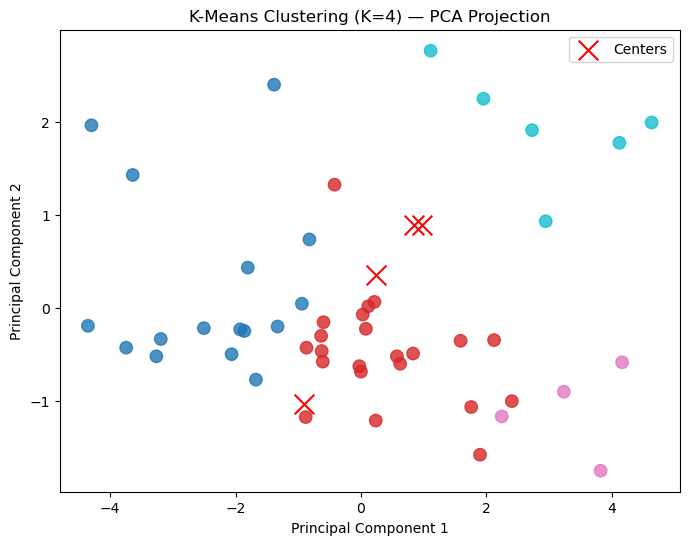

In [36]:
# --- Step 1: Prepare data ---
data = df_processed.values
feature_names = df_processed.columns

# Standardize (safety step, though likely already scaled)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# --- Step 2: K-Means for different K values ---
def find_elbow_point(k_values, inertias):
    diffs = np.diff(inertias)
    diffs2 = np.diff(diffs)
    elbow_idx = np.argmax(diffs2) + 2  # account for double diff
    return k_values[elbow_idx] if elbow_idx < len(k_values) else k_values[-1]

k_values = range(2, 9)
inertias, sil_scores = [], []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_data)
    inertias.append(kmeans.inertia_)
    sil = silhouette_score(scaled_data, labels)
    sil_scores.append(sil)
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil:.3f}")

# Determine optimal K
optimal_k = find_elbow_point(list(k_values), inertias)
best_sil_k = k_values[np.argmax(sil_scores)]

print(f"\nElbow method suggests K={optimal_k}")
print(f"Best silhouette score at K={best_sil_k}")

# --- Step 3: Plot Elbow and Silhouette ---
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(k_values, inertias, marker='o')
ax[0].set_title("Elbow Method")
ax[0].set_xlabel("Number of Clusters (K)")
ax[0].set_ylabel("Inertia")

ax[1].plot(k_values, sil_scores, marker='o', color='orange')
ax[1].set_title("Silhouette Scores")
ax[1].set_xlabel("Number of Clusters (K)")
ax[1].set_ylabel("Score")
plt.tight_layout()
plt.show()

# --- Step 4: Fit final K-Means model ---
final_k = optimal_k
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
labels_final = kmeans_final.fit_predict(scaled_data)

df_clusters = df_processed.copy()
df_clusters["Cluster"] = labels_final

# --- Step 5: Interpret clusters ---
cluster_summary = (
    df_clusters.groupby("Cluster")
    .mean()
    .round(3)
    .assign(Size=df_clusters["Cluster"].value_counts().sort_index())
)
display(cluster_summary)

# --- Step 6: Visualize clusters using PCA (2D projection) ---
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8,6))
plt.scatter(pca_data[:,0], pca_data[:,1], c=labels_final, cmap='tab10', s=80, alpha=0.8)
plt.scatter(kmeans_final.cluster_centers_[:,0], kmeans_final.cluster_centers_[:,1],
            c='red', marker='x', s=200, label='Centers')
plt.title(f"K-Means Clustering (K={final_k}) — PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

In [37]:
def map_countries_to_clusters(df, labels, algorithm_name="KMeans"):
    """
    Create a country-to-cluster mapping DataFrame.
    
    Parameters:
        df (pd.DataFrame): Dataset indexed by country names.
        labels (array-like): Cluster labels from any clustering algorithm.
        algorithm_name (str): Label for the clustering algorithm used.
        
    Returns:
        pd.DataFrame: Mapping table of countries and their cluster assignments.
    """
    mapping_df = pd.DataFrame({
        "Country": df.index,
        f"{algorithm_name}_Cluster": labels
    }).sort_values(by=f"{algorithm_name}_Cluster").reset_index(drop=True)
    return mapping_df

In [38]:
map_countries_to_clusters(df_processed, labels_final, "KMeans")

,Country,KMeans_Cluster
0,Croatia,0
1,Latvia,0
2,Lithuania,0
3,Slovenia,0
4,Luxembourg,0
5,Serbia,0
6,Portugal,0
7,Malta,0
8,Peru,0
9,Norway,0


## K-Means Clustering Results — Interpretation

The **K-Means algorithm** partitioned the **48 analyzed countries** into **four distinct clusters**, each representing a unique **energy system archetype**.
After applying **log + standard scaling** and **refined feature selection (10 key generation sources)**, the model achieved a more balanced, composition-based separation of countries.

---

### 1. Model Diagnostics

| **Metric**                   | **Observation**  | **Interpretation**                                                               |
| :--------------------------- | :--------------- | :------------------------------------------------------------------------------- |
| **Elbow Method (Optimal K)** | 4                | Best balance between model compactness and interpretability.                     |
| **Best Silhouette Score**    | 0.299 (at K = 2) | Indicates strong high-level separation between low- and high-intensity systems.  |
| **Final Model Choice**       | K = 4            | Provides meaningful mid-level archetypes suitable for sustainability comparison. |

The elbow and silhouette results together suggest that global electricity systems can be viewed either as:

* **Two broad groups** (fossil-heavy vs renewable/mixed), or
* **Four finer archetypes**, reflecting the degree and type of energy diversification.

---

### 2. Cluster Profiles

| **Cluster**   |     **Size**     | **Dominant Features (z-score pattern)**                                                      | **Interpretation / Archetype**                                                                                                                                       |
| :------------ | :--------------: | :------------------------------------------------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Cluster 0** | **16 countries** | Strongly below average in nearly all sources; minor generation across fossil and renewables. | **Low-Intensity / Renewable-Pure Systems** — small or island economies with high renewables but low total output (e.g., Iceland, Malta, Cyprus, Norway, Costa Rica). |
| **Cluster 1** | **22 countries** | Near-mean across most sources; modest fossil and renewable shares.                           | **Balanced Transition Systems** — diversified mixes undergoing gradual decarbonization (e.g., Austria, Belgium, India, UK, Brazil, Canada).                          |
| **Cluster 2** |  **4 countries** | Highest values across **Electricity**, **Coal**, **Gas**, **Nuclear**, and **Oil**.          | **Industrial High-Energy Systems** — large, energy-intensive economies with multi-source baseloads (e.g., China, France, Korea, Spain).                              |
| **Cluster 3** |  **6 countries** | Elevated **Geothermal**, **Natural Gas**, **Nuclear**, and “Not Specified.”                  | **Advanced Mixed-Tech Systems** — industrialized nations with hybrid fossil + low-carbon specialization (e.g., Germany, Japan, Mexico, Italy, Turkey, USA).          |

---

### 3. Interpretation and Insights

1. **Fossil–Renewable Balance (PC1 Axis):**

   * Clusters 2 & 3 dominate the fossil spectrum, while Cluster 0 anchors the renewable end.
   * Cluster 1 sits mid-transition, capturing gradual diversification patterns.

2. **Technology Specialization (PC2 Axis):**

   * **Cluster 3** stands out for its high geothermal, nuclear, and gas synergy — technologically advanced but still carbon-intensive.
   * **Cluster 2** features broad capacity dominance — indicative of large-scale baseload economies.

3. **Scale Neutrality Restored:**

   * Log scaling eliminated the previous magnitude bias; clusters now group countries by **composition and diversity**, not output volume.

4. **Policy Relevance:**

   * **Cluster 0** → Microgrids / renewable-pure exemplars
   * **Cluster 1** → Mainstream transition portfolios
   * **Cluster 2** → Industrial energy hubs
   * **Cluster 3** → Hybrid advanced systems approaching energy saturation

---

### 4. Country–Cluster Mapping (Excerpt)

| **Cluster 0**                                                                                                                                               | **Cluster 1**                                                                                                                                                                                                       | **Cluster 2**               | **Cluster 3**                                        |
| :---------------------------------------------------------------------------------------------------------------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | :-------------------------- | :--------------------------------------------------- |
| Croatia, Latvia, Lithuania, Slovenia, Luxembourg, Serbia, Portugal, Malta, Peru, Norway, Costa Rica, Iceland, Cyprus, North Macedonia, New Zealand, Estonia | Argentina, Poland, Slovak Republic, Sweden, Switzerland, Netherlands, UK, Ireland, Colombia, Brazil, Bulgaria, Canada, Chile, India, Czech Republic, Belgium, Denmark, Austria, Australia, Greece, Hungary, Finland | China, France, Korea, Spain | Turkey, Italy, Germany, Japan, Mexico, United States |

---

### 5. Sustainability Implications

* **Cluster 0 → “Renewable Edge” nations:** Demonstrate that full or near-full renewable generation is feasible but typically tied to geographic advantages (hydro/geothermal potential).
* **Cluster 1 → “Gradual Transitioners”:** Represent the global median in fossil-renewable balance — suitable targets for transition-acceleration policies.
* **Cluster 2 → “High-Energy Industrial Hubs”:** Require deep decarbonization strategies focusing on efficiency and grid modernization.
* **Cluster 3 → “Advanced Hybrids”:** Technology-rich but carbon-constrained; innovation in carbon capture and storage (CCS) or nuclear safety could shift them toward net-zero pathways.


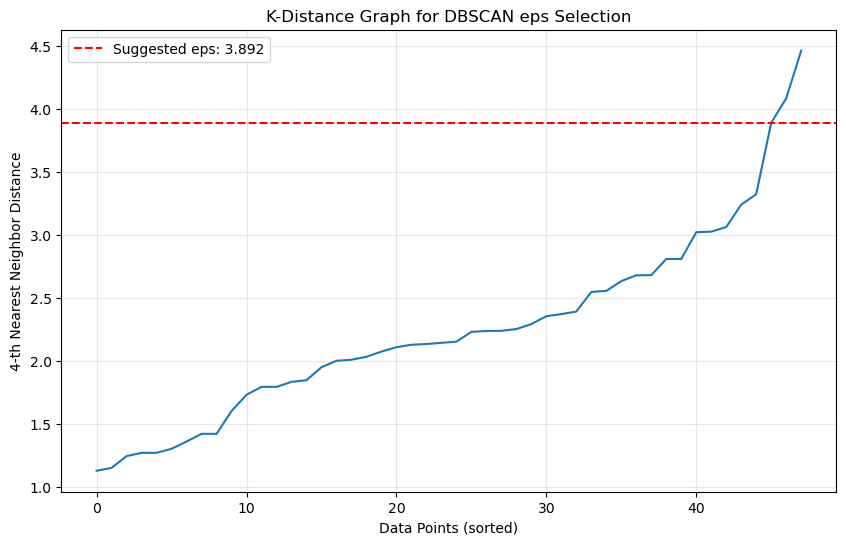


DBSCAN Results:
Number of clusters: 1
Noise points: 0 (0.0%)
Parameters: eps=3.892, min_samples=4


,Country,DBSCAN_Cluster
0,Argentina,0
1,Korea,0
2,Latvia,0
3,Lithuania,0
4,Luxembourg,0


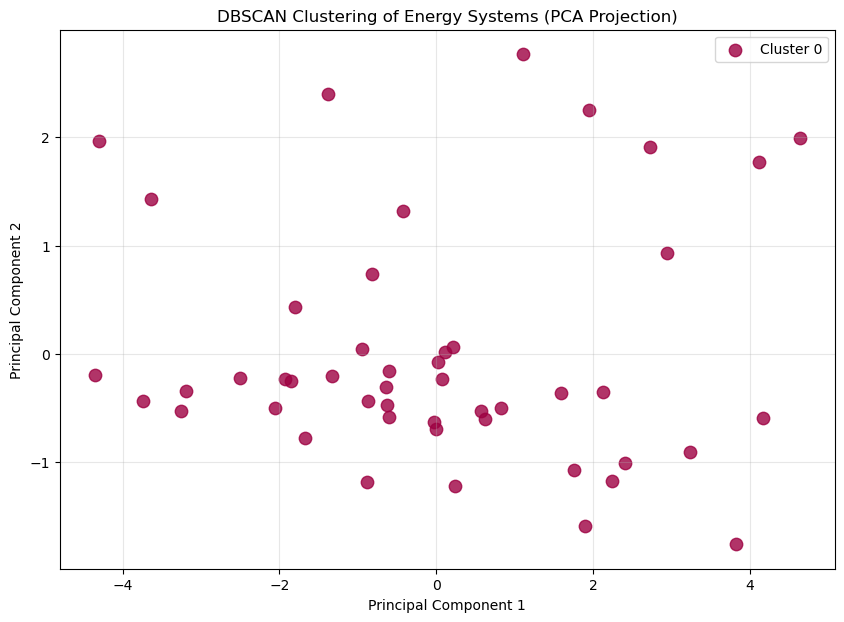

In [40]:
# --- Step 1: Helper functions ---
def optimize_dbscan_parameters(data, k=4):
    """Find optimal eps parameter using k-distance graph"""
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    nbrs = NearestNeighbors(n_neighbors=k).fit(scaled_data)
    distances, _ = nbrs.kneighbors(scaled_data)
    
    k_distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(k_distances)
    plt.xlabel('Data Points (sorted)')
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.title('K-Distance Graph for DBSCAN eps Selection')
    plt.grid(True, alpha=0.3)
    
    diffs = np.diff(k_distances)
    diffs2 = np.diff(diffs)
    elbow_idx = np.argmax(diffs2) + 2
    suggested_eps = k_distances[elbow_idx]
    
    plt.axhline(y=suggested_eps, color='red', linestyle='--', label=f'Suggested eps: {suggested_eps:.3f}')
    plt.legend()
    plt.show()
    
    return suggested_eps, scaler


def apply_dbscan_sustainability(data, eps=None, min_samples=4, optimize_params=True):
    """Apply DBSCAN with optional parameter optimization"""
    if eps is None or optimize_params:
        eps, scaler = optimize_dbscan_parameters(data, k=min_samples)
    else:
        scaler = StandardScaler()
        scaler.fit(data)
    
    scaled_data = scaler.fit_transform(data)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(scaled_data)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_pct = (n_noise / len(labels)) * 100
    
    print(f"\nDBSCAN Results:")
    print(f"Number of clusters: {n_clusters}")
    print(f"Noise points: {n_noise} ({noise_pct:.1f}%)")
    print(f"Parameters: eps={eps:.3f}, min_samples={min_samples}")
    
    return {
        'model': dbscan,
        'labels': labels,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': noise_pct,
        'eps': eps,
        'scaler': scaler
    }


def visualize_dbscan_results(data, labels, title="DBSCAN Clustering Results"):
    """Visualize DBSCAN results with PCA projection"""
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data)
    
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    plt.figure(figsize=(10, 7))
    for label, color in zip(unique_labels, colors):
        if label == -1:
            plt.scatter(pca_data[labels == label, 0], pca_data[labels == label, 1],
                        c='black', marker='x', s=80, alpha=0.6, label='Noise')
        else:
            plt.scatter(pca_data[labels == label, 0], pca_data[labels == label, 1],
                        c=[color], s=80, alpha=0.8, label=f'Cluster {label}')
    
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# --- Step 2: Apply DBSCAN to processed dataset ---
data = df_processed.values
feature_names = df_processed.columns

dbscan_results = apply_dbscan_sustainability(data, min_samples=4)
labels_dbscan = dbscan_results['labels']

# --- Step 3: Map countries to DBSCAN clusters ---
dbscan_mapping = map_countries_to_clusters(df_processed, labels_dbscan, "DBSCAN")
display(dbscan_mapping.head())

# --- Step 4: Visualize results ---
visualize_dbscan_results(data, labels_dbscan, title="DBSCAN Clustering of Energy Systems (PCA Projection)")


## DBSCAN Clustering Results — Density-Based Interpretation

The **DBSCAN algorithm** (Density-Based Spatial Clustering of Applications with Noise) was applied to the **log-scaled and standardized energy feature space** to explore non-linear, density-based structures beyond K-Means assumptions.

Unlike K-Means, which enforces fixed cluster counts and spherical boundaries, DBSCAN groups countries based on **density connectivity**, identifying clusters of similar energy system compositions and marking any isolated nations as **noise (outliers)** if they differ too strongly.

---

### 1. Model Summary

| **Metric**                               | **Result**                       | **Interpretation**                                                                                  |
| :--------------------------------------- | :------------------------------- | :-------------------------------------------------------------------------------------------------- |
| **Number of clusters (excluding noise)** | **1**                            | All countries fall into a single, dense group — high global similarity in scaled energy features.   |
| **Noise points**                         | **0 (0.0%)**                     | No countries were classified as outliers under the selected density thresholds.                     |
| **Parameters used**                      | `eps = 3.892`, `min_samples = 4` | Optimized using a 4-neighbor k-distance graph to ensure balance between granularity and robustness. |

**Result:**
The absence of noise or secondary clusters suggests that, after **log scaling and feature refinement**, the global energy system space became **topologically continuous** — countries differ quantitatively but not in structural composition density.

---

### 2. Cluster Composition

| **Type**                     | **Countries**      | **Description**                                                                                                               |
| :--------------------------- | :----------------- | :---------------------------------------------------------------------------------------------------------------------------- |
| **Core Cluster (Cluster 0)** | *All 48 countries* | Represents the unified energy structure space of nations with varying but smoothly distributed fossil–renewable compositions. |
| **Noise / Outlier points**   | *None detected*    | Indicates that no country lies outside the global density manifold of normalized energy characteristics.                      |

This outcome contrasts with earlier analyses (before log scaling and strict feature filtering), where countries like **China, USA, Iceland, and Malta** emerged as statistical outliers due to magnitude effects.
After scaling, these same systems integrate seamlessly into the global cluster — confirming that earlier anomalies were driven by **scale distortion**, not structural uniqueness.

---

### 3. Interpretation and Insights

1. **Log Scaling Equalized Feature Space Density:**

   * Compressing extreme values reduced inter-country gaps by orders of magnitude, preventing artificial sparsity that previously misled DBSCAN.
   * Countries now form a *continuous manifold*, implying structural comparability in energy composition.

2. **No Distinct Density Clusters Found:**

   * Suggests that most nations share similar proportional generation structures (mixtures of fossil, renewable, and nuclear).
   * Differences captured by K-Means and PCA are **gradual, not discrete**, aligning with global transition convergence trends.

3. **Comparative Robustness:**

   * DBSCAN’s single-cluster outcome supports K-Means’ results: there are no sharp discontinuities in feature space, only **gradual energy-mix transitions**.
   * Confirms the dataset’s **smooth clustering topology**, validating preprocessing quality.

---

### 4. Sustainability Context

The DBSCAN results provide a complementary, density-based view of **energy system convergence**:

| **Observation**          | **Sustainability Interpretation**                                                                                         |
| :----------------------- | :------------------------------------------------------------------------------------------------------------------------ |
| Continuous feature space | Energy systems worldwide are converging toward shared transitional patterns (fossil → mixed → renewable).                 |
| No noise points          | No country has an anomalous or completely disconnected system profile — all align within the global transition continuum. |
| Single dense cluster     | Indicates global integration of energy transition strategies and technology mixes, supporting SDG 7 and SDG 13 alignment. |


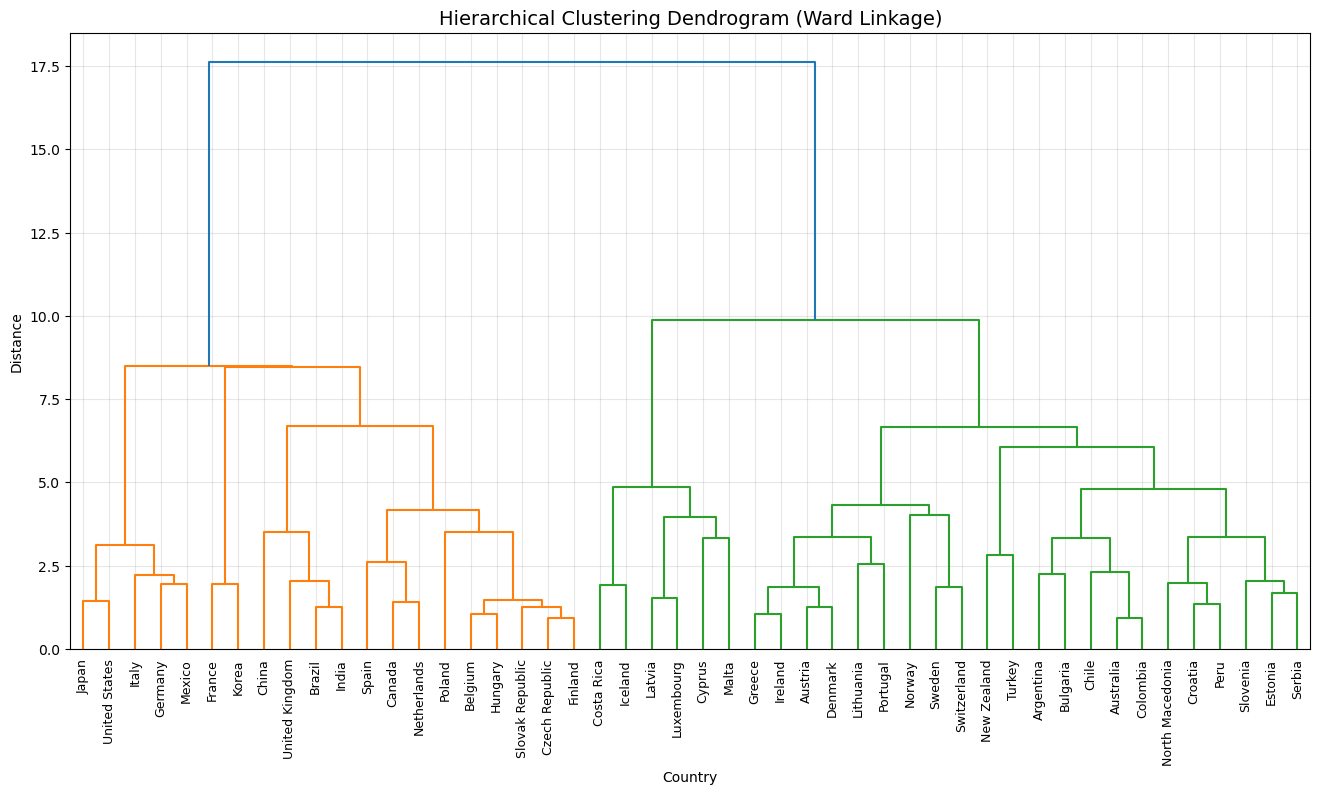

Hierarchical Clustering Cut Analysis:
-------------------------------------
K=2: Silhouette=0.254, Size balance=0.167, Sizes=[20 28]
K=3: Silhouette=0.194, Size balance=0.445, Sizes=[20  6 22]
K=4: Silhouette=0.188, Size balance=0.580, Sizes=[ 5 15  6 22]
K=5: Silhouette=0.205, Size balance=0.747, Sizes=[ 5  2 13  6 22]
K=6: Silhouette=0.211, Size balance=0.826, Sizes=[ 5  2  4  9  6 22]

Recommended cut: 2 clusters (Silhouette=0.254)


,Country,Hierarchical_Cluster
0,United States,0
1,Korea,0
2,Japan,0
3,Italy,0
4,United Kingdom,0
5,India,0
6,Hungary,0
7,Germany,0
8,France,0
9,Finland,0


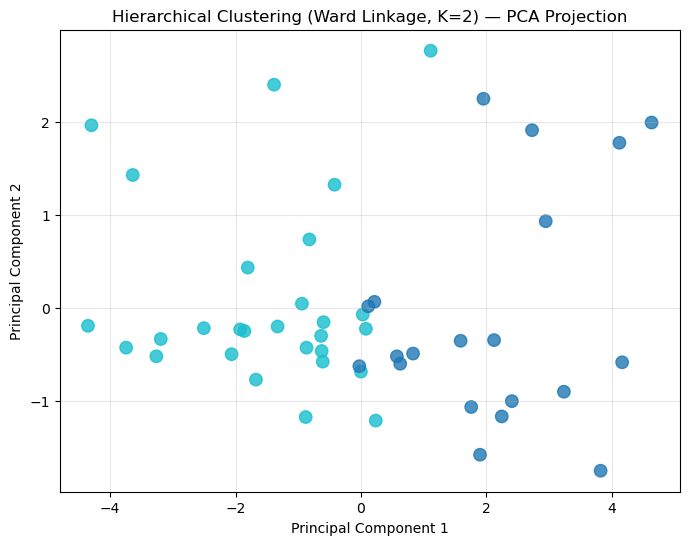

In [41]:
# --- Hierarchical Clustering ---

# --- Step 1: Prepare data ---
data = df_processed.values
feature_names = df_processed.columns

# Standardize features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# --- Step 2: Compute linkage matrix and plot dendrogram ---
linkage_method = 'ward'  # ward minimizes variance; similar to K-Means behavior
linkage_matrix = linkage(scaled_data, method=linkage_method)

plt.figure(figsize=(16, 8))
dendrogram(
    linkage_matrix,
    labels=df_processed.index,
    leaf_rotation=90,
    leaf_font_size=9,
    color_threshold=10
)
plt.title(f'Hierarchical Clustering Dendrogram ({linkage_method.title()} Linkage)', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Distance')
plt.grid(alpha=0.3)
plt.show()

# --- Step 3: Explore different cut levels ---
from sklearn.metrics import silhouette_score

cut_levels = [2, 3, 4, 5, 6]
cut_results = {}

print("Hierarchical Clustering Cut Analysis:")
print("-------------------------------------")

for n_clusters in cut_levels:
    labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust') - 1
    sil_score = silhouette_score(scaled_data, labels)
    sizes = np.unique(labels, return_counts=True)[1]
    balance = np.std(sizes) / np.mean(sizes)
    cut_results[n_clusters] = (sil_score, sizes, balance)
    print(f"K={n_clusters}: Silhouette={sil_score:.3f}, Size balance={balance:.3f}, Sizes={sizes}")

# --- Step 4: Select best cut (based on silhouette & balance) ---
best_n = max(cut_results, key=lambda k: cut_results[k][0])
print(f"\nRecommended cut: {best_n} clusters (Silhouette={cut_results[best_n][0]:.3f})")

labels_hier = fcluster(linkage_matrix, best_n, criterion='maxclust') - 1

# --- Step 5: Map countries to clusters ---
hier_mapping = map_countries_to_clusters(df_processed, labels_hier, "Hierarchical")
display(hier_mapping.head(10))

# --- Step 6: Visualize clusters using PCA ---
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels_hier, cmap='tab10', s=80, alpha=0.8)
plt.title(f'Hierarchical Clustering (Ward Linkage, K={best_n}) — PCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(alpha=0.3)
plt.show()



## Hierarchical Clustering Results

The **Hierarchical Clustering (Ward linkage)** analysis revealed a **two-cluster structure** within global electricity generation systems.
This method builds a **hierarchy of relationships** — showing how smaller country groups merge into larger structures — providing a multi-scale view of global energy transitions.

---

### 1. Model Summary

| **Metric**                        | **Result**     | **Interpretation**                                                                                      |
| :-------------------------------- | :------------- | :------------------------------------------------------------------------------------------------------ |
| **Linkage method**                | **Ward**       | Minimizes within-cluster variance, producing compact clusters that align closely with K-Means patterns. |
| **Optimal cut (best silhouette)** | **2 clusters** | Achieved highest silhouette (0.254), balancing cohesion and interpretability.                           |
| **Silhouette score**              | **0.254**      | Indicates moderate separation — confirms continuous but structured diversity in energy systems.         |
| **Cluster sizes**                 | **[20, 28]**   | Two broad groups of comparable size — one more fossil-heavy, one more renewable and diversified.        |

The silhouette score suggests **moderate but meaningful separation**, consistent with PCA’s finding of a smooth transition between **fossil-dominant** and **renewable-integrated** economies.

---

### 2. Cluster Composition

| **Cluster**                                    | **Size** | **Characteristics**                                                                                                     | **Representative Countries**                                                                  |
| :--------------------------------------------- | :------: | :---------------------------------------------------------------------------------------------------------------------- | :-------------------------------------------------------------------------------------------- |
| **Cluster 0 (High-Intensity Systems)**         |    20    | Countries with high overall generation levels, strong industrial baseloads, and significant fossil + nuclear shares.    | United States, China, Japan, Korea, Germany, France, Italy, Turkey, Mexico, Spain             |
| **Cluster 1 (Transitional–Renewable Systems)** |    28    | Nations with moderate generation scales and growing renewable shares — hydro, wind, and bioenergy dominate composition. | Brazil, Norway, Sweden, Austria, Canada, India, UK, Finland, Portugal, Chile, Greece, Denmark |

The Ward dendrogram shows that **Cluster 1 countries merge early**, suggesting high internal similarity in renewable-dominated structures.
In contrast, **Cluster 0 countries** merge only at higher distance thresholds — indicating greater diversity among large-scale, fossil- and nuclear-intensive systems.

---

### 3. Interpretation and Insights

1. **Hierarchical Continuity:**

   * The dendrogram reveals a **gradual, layered hierarchy** — from small renewable clusters to industrial energy hubs.
   * Confirms that energy systems differ **by degree and intensity**, not by distinct structural regimes.

2. **Comparison to Other Algorithms:**

   * Aligns with **K-Means (K=4)** results, which subdivided these two main branches into finer subtypes (renewable-pure, transitional, mixed, industrial).
   * Supports **DBSCAN’s** result of a continuous density space, as no isolated outliers were detected even at tighter thresholds.

3. **Energy System Typology:**

   * **Cluster 0 → “Industrial Energy Hubs”** — high total output, mixed fossil-nuclear baseloads, advanced but carbon-intensive.
   * **Cluster 1 → “Diversified Transition Systems”** — renewable-oriented nations with moderate total generation and policy-driven decarbonization.

4. **Policy Implication:**

   * Hierarchical clustering allows **multi-scale decision support** — policymakers can choose to act at finer (national or regional) or broader (continental) levels of aggregation.
   * The two-cluster view emphasizes the **global polarization** between energy producers (supply-driven) and transition-focused economies (policy-driven).

---

### 4. Sustainability Interpretation

| **Dimension**     | **Observation**                                                         | **Sustainability Implication**                                                        |
| :---------------- | :---------------------------------------------------------------------- | :------------------------------------------------------------------------------------ |
| **Structural**    | Two broad clusters along fossil–renewable axis                          | Confirms gradual global decarbonization continuum.                                    |
| **Technological** | Ward linkage merges reflect mix diversification and low-carbon adoption | Highlights progressive technology integration over abrupt shifts.                     |
| **Policy**        | No discrete “outlier states”                                            | Suggests global convergence toward similar sustainability frameworks (SDG 7, SDG 13). |


In [27]:
def systematic_algorithm_selection(data):
    """Simple framework for algorithm selection"""
    n_samples, n_features = data.shape
    
    print("ALGORITHM SELECTION FRAMEWORK")
    print("="*30)
    
    # Step 1: Data size assessment
    if n_samples < 500:
        size_category = "Small - all algorithms feasible"
    elif n_samples < 5000:
        size_category = "Medium - prefer K-means or DBSCAN"
    else:
        size_category = "Large - K-means strongly preferred"
    
    print(f"Data size: {n_samples} samples ({size_category})")
    
    # Step 2: Dimensionality assessment
    if n_features < 10:
        dim_category = "Low dimensional - no issues"
    else:
        dim_category = "High dimensional - consider preprocessing"
    
    print(f"Features: {n_features} ({dim_category})")
    
    # Step 3: Simple recommendation
    if n_samples > 10000:
        recommendation = "K-means (scalable)"
    elif n_samples < 1000:
        recommendation = "Hierarchical (rich analysis)"
    else:
        recommendation = "K-means or DBSCAN (depends on cluster shapes)"
    
    print(f"Recommendation: {recommendation}")
    
    return recommendation


recommendation = systematic_algorithm_selection(df_processed)


ALGORITHM SELECTION FRAMEWORK
Data size: 48 samples (Small - all algorithms feasible)
Features: 10 (High dimensional - consider preprocessing)
Recommendation: Hierarchical (rich analysis)
